<a href="https://colab.research.google.com/github/YonghwanYim/RL-toy-example/blob/main/RL_Toy_Example_29_s5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning + RL
(NASA C-MAPSS dataset)

# Data Handling

Connect with Google Drive

In [3]:
from google.colab import drive
drive.mount('content')

Mounted at content


Importing libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import warnings
np.random.seed(34)
warnings.filterwarnings('ignore')

Defining features names

In [5]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

Importing train and validation data

* Data Set : FD001
* Train trajectories : 100
* Test trajectories : 100
* Conditions : ONE (Sea Level)
* Fault Modes : ONE (HPC Degradation)

Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. here are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.





**Data Set: FD002**
*   Train trjectories: 260
*   Conditions: SIX
*   Fault Modes: ONE (HPC Degradation)

**Data Set: FD003**
* Train trjectories: 100
* Conditions: ONE (Sea Level)
* Fault Modes: TWO (HPC Degradation, Fan Degradation)

**Data Set: FD004**
* Train trjectories: 249
* Conditions: SIX
* Fault Modes: TWO (HPC Degradation, Fan Degradation)

In [6]:
dftrain = pd.read_csv('/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/train_FD001_1_70.txt',sep='\s+',header=None,index_col=False,names=col_names)
dfvalid = pd.read_csv('/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/train_FD001_71_100.txt',sep='\s+',header=None,index_col=False,names=col_names)
dffull_data = pd.read_csv('/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
# y_valid : A vector of true Remaining Useful Life (RUL) values for the test data.
# y_valid = pd.read_csv('/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])
# dfvalid.shape

In [7]:
train = dftrain.copy() # Engine 1~70 (dataset 1)
valid = dfvalid.copy() # Engine 71~100 (dataset 1)
full_data = dffull_data.copy() # Engine 1~100 (dataset 1)

Data inspection

In [8]:
train

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1  \
0                1            1    -0.0007    -0.0004      100.0  518.67   
1                1            2     0.0019    -0.0003      100.0  518.67   
2                1            3    -0.0043     0.0003      100.0  518.67   
3                1            4     0.0007     0.0000      100.0  518.67   
4                1            5    -0.0019    -0.0002      100.0  518.67   
...            ...          ...        ...        ...        ...     ...   
14125           70          133    -0.0015    -0.0001      100.0  518.67   
14126           70          134    -0.0012    -0.0004      100.0  518.67   
14127           70          135     0.0004     0.0003      100.0  518.67   
14128           70          136    -0.0044     0.0000      100.0  518.67   
14129           70          137     0.0014    -0.0000      100.0  518.67   

          s_2      s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  \
0      641.82  1589.70  1400.60  14.62  ...  521.66  2388.02  8138.62  8.4195   
1      642.15  1591.82  1403.14  14.62  ...  522.28  2388.07  8131.49  8.4318   
2      642.35  1587.99  1404.20  14.62  ...  522.42  2388.03  8133.23  8.4178   
3      642.35  1582.79  1401.87  14.62  ...  522.86  2388.08  8133.83  8.3682   
4      642.37  1582.85  1406.22  14.62  ...  522.19  2388.04  8133.80  8.4294   
...       ...      ...      ...    ...  ...     ...      ...      ...     ...   
14125  644.10  1601.31  1430.27  14.62  ...  519.83  2388.23  8167.97  8.4984   
14126  644.09  1605.88  1430.21  14.62  ...  519.38  2388.18  8172.19  8.5328   
14127  643.55  1596.63  1426.86  14.62  ...  519.38  2388.20  8167.46  8.5118   
14128  643.79  1601.30  1427.36  14.62  ...  519.77  2388.25  8165.57  8.5529   
14129  643.39  1602.76  1434.81  14.62  ...  519.60  2388.25  8173.73  8.5312   

       s_16  s_17  s_18   s_19   s_20     s_21  
0      0.03   392  2388  100.0  39.06  23.4190  
1      0.03   392  2388  100.0  39.00  23.4236  
2      0.03   390  2388  100.0  38.95  23.3442  
3      0.03   392  2388  100.0  38.88  23.3739  
4      0.03   393  2388  100.0  38.90  23.4044  
...     ...   ...   ...    ...    ...      ...  
14125  0.03   396  2388  100.0  38.41  23.1364  
14126  0.03   397  2388  100.0  38.28  23.0637  
14127  0.03   396  2388  100.0  38.48  23.0993  
14128  0.03   398  2388  100.0  38.24  23.0289  
14129  0.03   396  2388  100.0  38.49  23.1398  

[14130 rows x 26 columns]

In [9]:
valid

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1  \
0              71            1     0.0027    -0.0004      100.0  518.67   
1              71            2     0.0029    -0.0003      100.0  518.67   
2              71            3     0.0007     0.0003      100.0  518.67   
3              71            4    -0.0014     0.0003      100.0  518.67   
4              71            5     0.0015     0.0001      100.0  518.67   
...           ...          ...        ...        ...        ...     ...   
6496          100          196    -0.0004    -0.0003      100.0  518.67   
6497          100          197    -0.0016    -0.0005      100.0  518.67   
6498          100          198     0.0004     0.0000      100.0  518.67   
6499          100          199    -0.0011     0.0003      100.0  518.67   
6500          100          200    -0.0032    -0.0005      100.0  518.67   

         s_2      s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  \
0     642.64  1581.95  1407.04  14.62  ...  521.90  2388.13  8126.82  8.4372   
1     642.82  1593.17  1403.53  14.62  ...  521.24  2388.10  8124.84  8.4068   
2     642.50  1582.94  1402.54  14.62  ...  521.85  2388.09  8123.24  8.4233   
3     643.04  1584.90  1409.75  14.62  ...  521.62  2388.08  8123.70  8.4352   
4     642.00  1587.63  1400.43  14.62  ...  521.50  2388.04  8123.08  8.4395   
...      ...      ...      ...    ...  ...     ...      ...      ...     ...   
6496  643.49  1597.98  1428.63  14.62  ...  519.49  2388.26  8137.60  8.4956   
6497  643.54  1604.50  1433.58  14.62  ...  519.68  2388.22  8136.50  8.5139   
6498  643.42  1602.46  1428.18  14.62  ...  520.01  2388.24  8141.05  8.5646   
6499  643.23  1605.26  1426.53  14.62  ...  519.67  2388.23  8139.29  8.5389   
6500  643.85  1600.38  1432.14  14.62  ...  519.30  2388.26  8137.33  8.5036   

      s_16  s_17  s_18   s_19   s_20     s_21  
0     0.03   391  2388  100.0  38.99  23.2399  
1     0.03   392  2388  100.0  38.85  23.2887  
2     0.03   394  2388  100.0  38.92  23.3668  
3     0.03   392  2388  100.0  38.89  23.2722  
4     0.03   393  2388  100.0  39.03  23.2896  
...    ...   ...   ...    ...    ...      ...  
6496  0.03   397  2388  100.0  38.49  22.9735  
6497  0.03   395  2388  100.0  38.30  23.1594  
6498  0.03   398  2388  100.0  38.44  22.9333  
6499  0.03   395  2388  100.0  38.29  23.0640  
6500  0.03   396  2388  100.0  38.37  23.0522  

[6501 rows x 26 columns]

In [10]:
full_data

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1  \
0                1            1    -0.0007    -0.0004      100.0  518.67   
1                1            2     0.0019    -0.0003      100.0  518.67   
2                1            3    -0.0043     0.0003      100.0  518.67   
3                1            4     0.0007     0.0000      100.0  518.67   
4                1            5    -0.0019    -0.0002      100.0  518.67   
...            ...          ...        ...        ...        ...     ...   
20626          100          196    -0.0004    -0.0003      100.0  518.67   
20627          100          197    -0.0016    -0.0005      100.0  518.67   
20628          100          198     0.0004     0.0000      100.0  518.67   
20629          100          199    -0.0011     0.0003      100.0  518.67   
20630          100          200    -0.0032    -0.0005      100.0  518.67   

          s_2      s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  \
0      641.82  1589.70  1400.60  14.62  ...  521.66  2388.02  8138.62  8.4195   
1      642.15  1591.82  1403.14  14.62  ...  522.28  2388.07  8131.49  8.4318   
2      642.35  1587.99  1404.20  14.62  ...  522.42  2388.03  8133.23  8.4178   
3      642.35  1582.79  1401.87  14.62  ...  522.86  2388.08  8133.83  8.3682   
4      642.37  1582.85  1406.22  14.62  ...  522.19  2388.04  8133.80  8.4294   
...       ...      ...      ...    ...  ...     ...      ...      ...     ...   
20626  643.49  1597.98  1428.63  14.62  ...  519.49  2388.26  8137.60  8.4956   
20627  643.54  1604.50  1433.58  14.62  ...  519.68  2388.22  8136.50  8.5139   
20628  643.42  1602.46  1428.18  14.62  ...  520.01  2388.24  8141.05  8.5646   
20629  643.23  1605.26  1426.53  14.62  ...  519.67  2388.23  8139.29  8.5389   
20630  643.85  1600.38  1432.14  14.62  ...  519.30  2388.26  8137.33  8.5036   

       s_16  s_17  s_18   s_19   s_20     s_21  
0      0.03   392  2388  100.0  39.06  23.4190  
1      0.03   392  2388  100.0  39.00  23.4236  
2      0.03   390  2388  100.0  38.95  23.3442  
3      0.03   392  2388  100.0  38.88  23.3739  
4      0.03   393  2388  100.0  38.90  23.4044  
...     ...   ...   ...    ...    ...      ...  
20626  0.03   397  2388  100.0  38.49  22.9735  
20627  0.03   395  2388  100.0  38.30  23.1594  
20628  0.03   398  2388  100.0  38.44  22.9333  
20629  0.03   395  2388  100.0  38.29  23.0640  
20630  0.03   396  2388  100.0  38.37  23.0522  

[20631 rows x 26 columns]

In [11]:
print('Shape of the train dataset : ',train.shape)
print('Shape of the validation dataset : ',valid.shape)
print('Percentage of the validation dataset : ',len(valid)/(len(valid)+len(train)))

Shape of the train dataset :  (14130, 26)
Shape of the validation dataset :  (6501, 26)
Percentage of the validation dataset :  0.31510833212156464


Add RUL column to the data

RUL corresponds to the remaining time cycles for each unit before it falls.

In [12]:
def add_RUL_column(df):
    train_grouped_by_unit = df.groupby(by='unit_number')
    max_time_cycles = train_grouped_by_unit['time_cycles'].max()
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    merged = merged.drop("max_time_cycle", axis=1)
    return merged

In [13]:
train = add_RUL_column(train)
valid = add_RUL_column(valid)
full_data = add_RUL_column(full_data)

In [14]:
train[['unit_number','RUL']] # Jet Engine 1~70 (total : 70)

unit_number  RUL
0                1  191
1                1  190
2                1  189
3                1  188
4                1  187
...            ...  ...
14125           70    4
14126           70    3
14127           70    2
14128           70    1
14129           70    0

[14130 rows x 2 columns]

In [15]:
valid[['unit_number','RUL']] # Jet Engine 71~100 (total : 30)

unit_number  RUL
0              71  207
1              71  206
2              71  205
3              71  204
4              71  203
...           ...  ...
6496          100    4
6497          100    3
6498          100    2
6499          100    1
6500          100    0

[6501 rows x 2 columns]

In [16]:
full_data[['unit_number', 'RUL']]

unit_number  RUL
0                1  191
1                1  190
2                1  189
3                1  188
4                1  187
...            ...  ...
20626          100    4
20627          100    3
20628          100    2
20629          100    1
20630          100    0

[20631 rows x 2 columns]

In [17]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['s_'+str(i)]=x
    i+=1
Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

Plotting the evolution of features (sensors) along with the evolution with RUL

In [18]:
def plot_signal(df, Sensor_dic, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
      #plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(10).mean())
       if (i % 5 == 0):   #For a better visualisation, we plot the sensors signals of 10 units only (data : FD001)
           plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(10).mean())

    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero  # xlim() : range of x-axis
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(Sensor_dic[signal_name])
    plt.xlabel('Remaining Useful Life')
    plt.show()

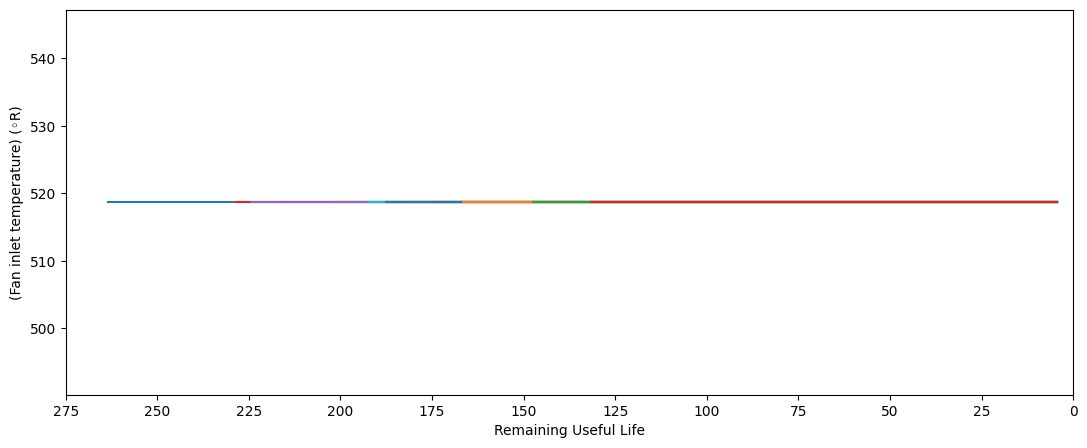

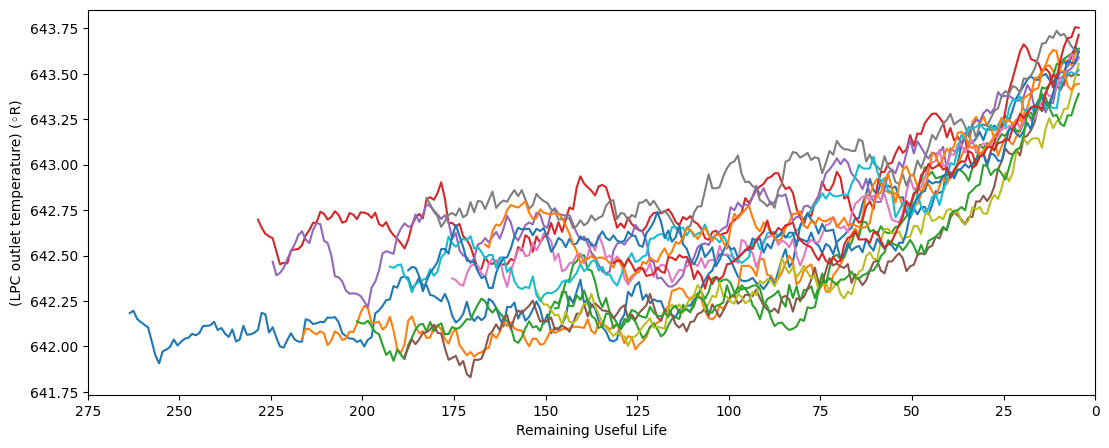

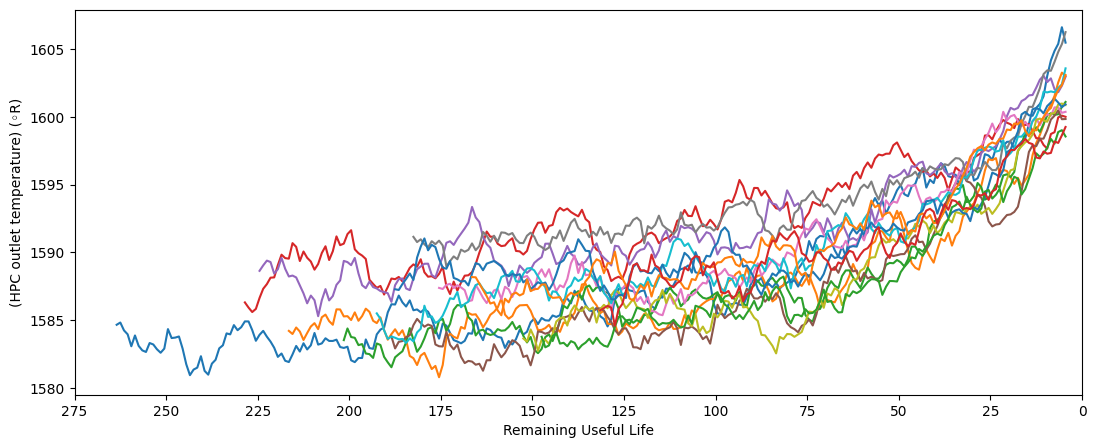

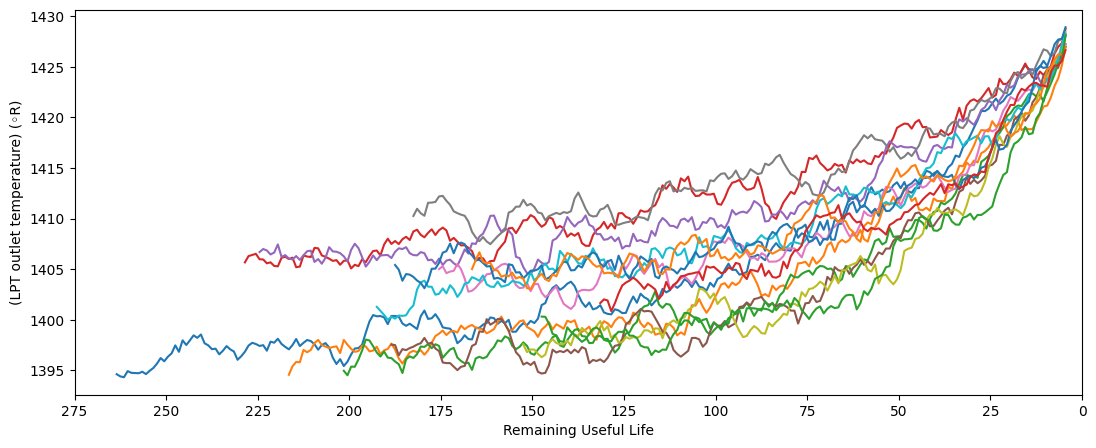

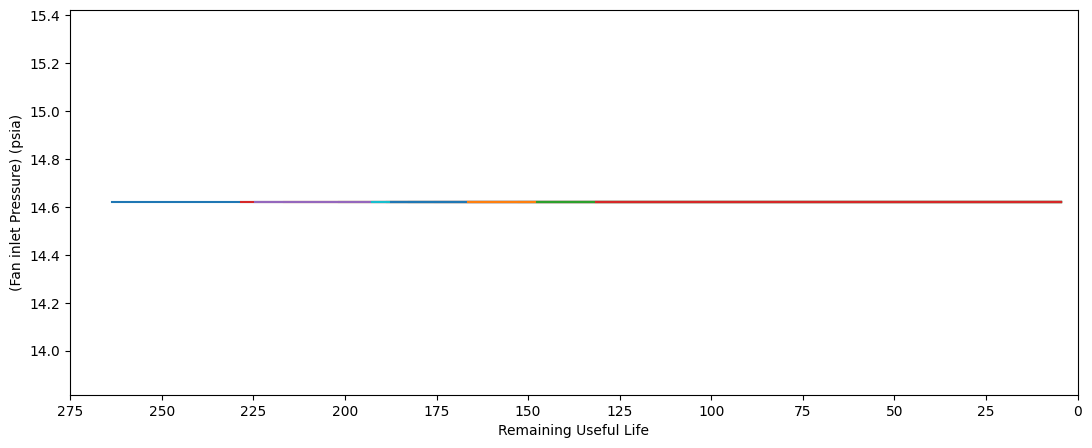

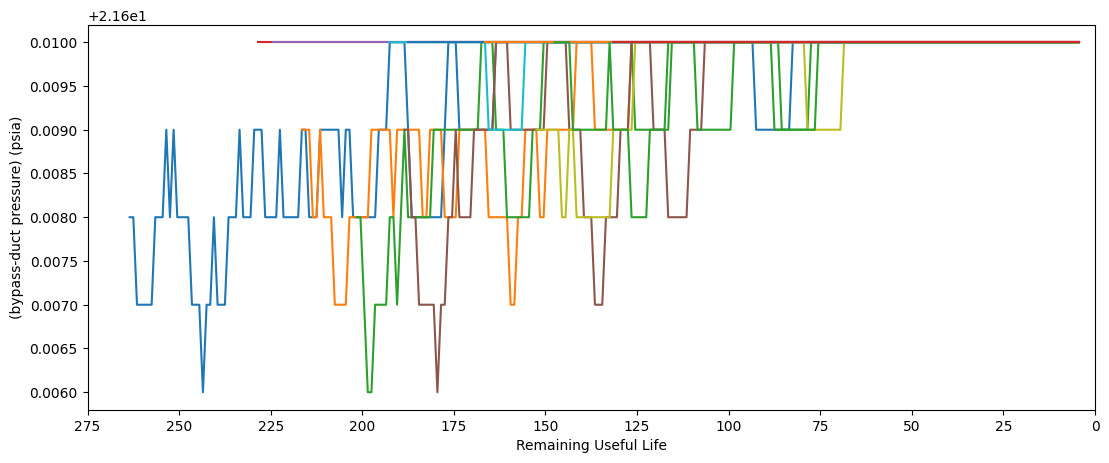

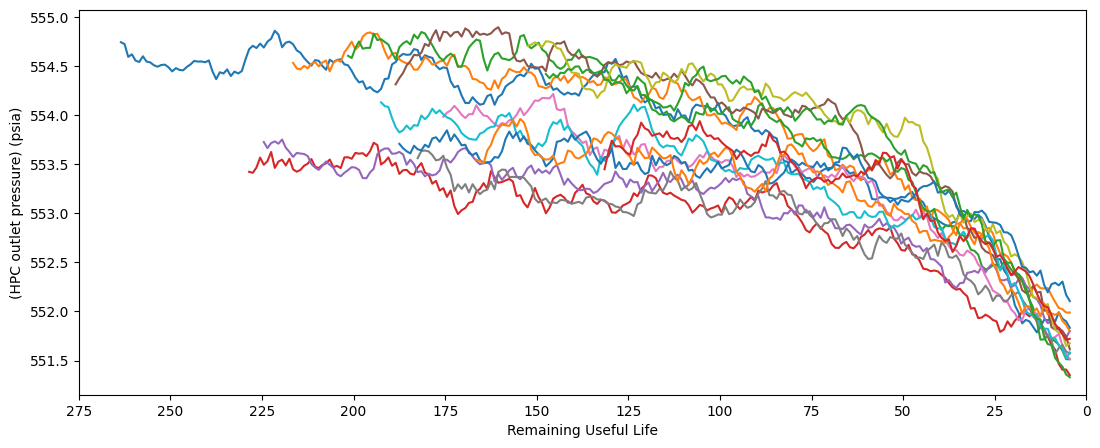

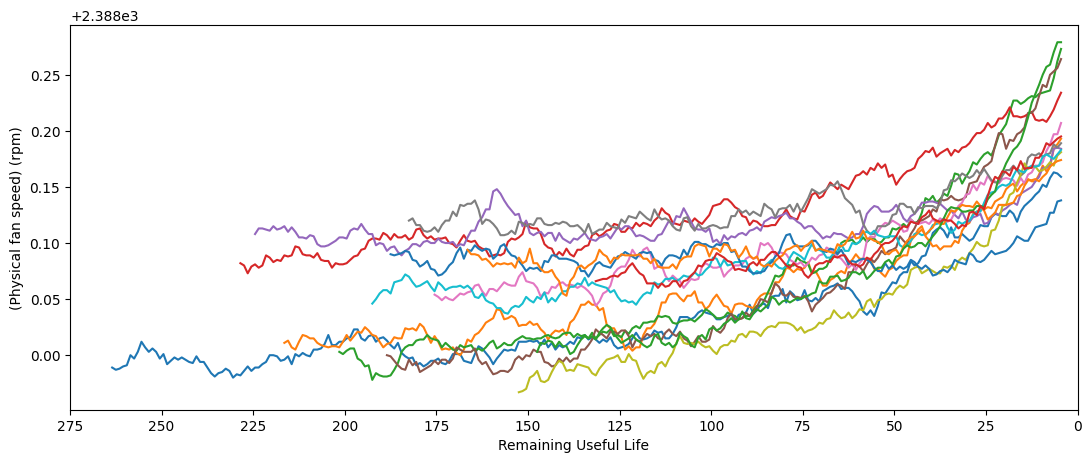

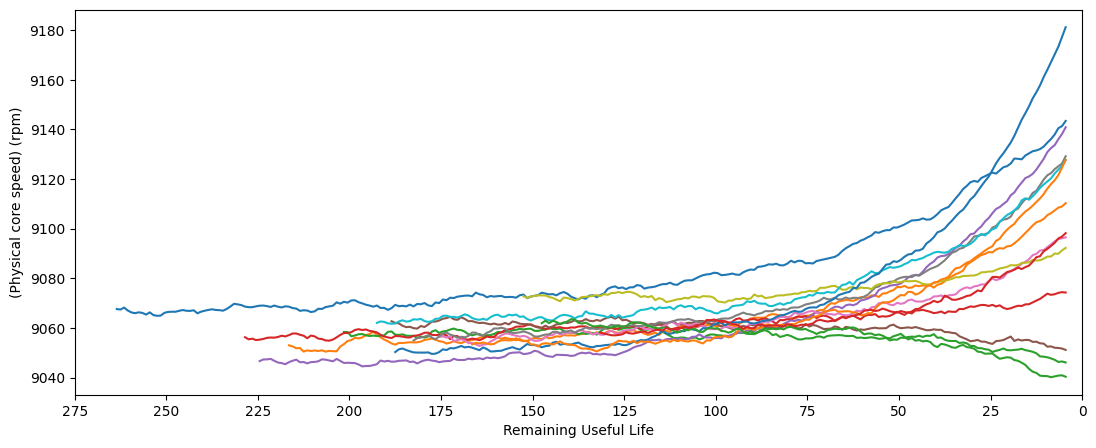

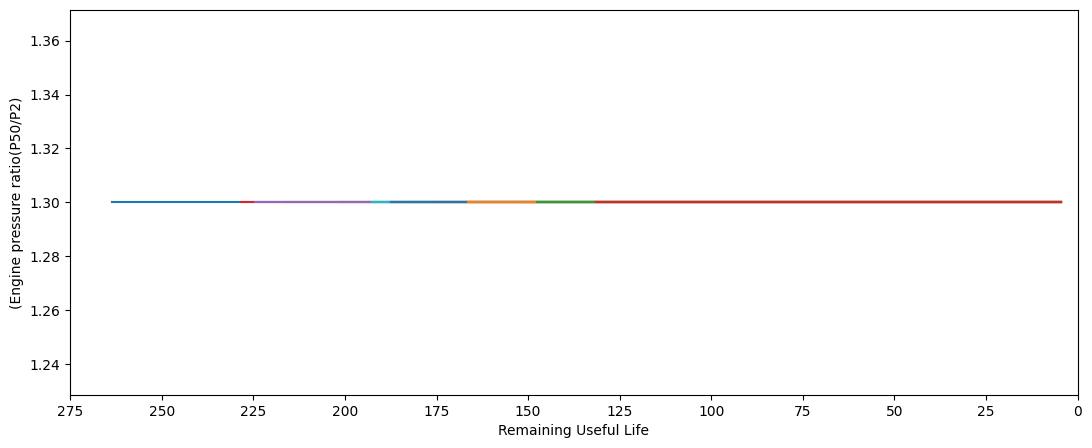

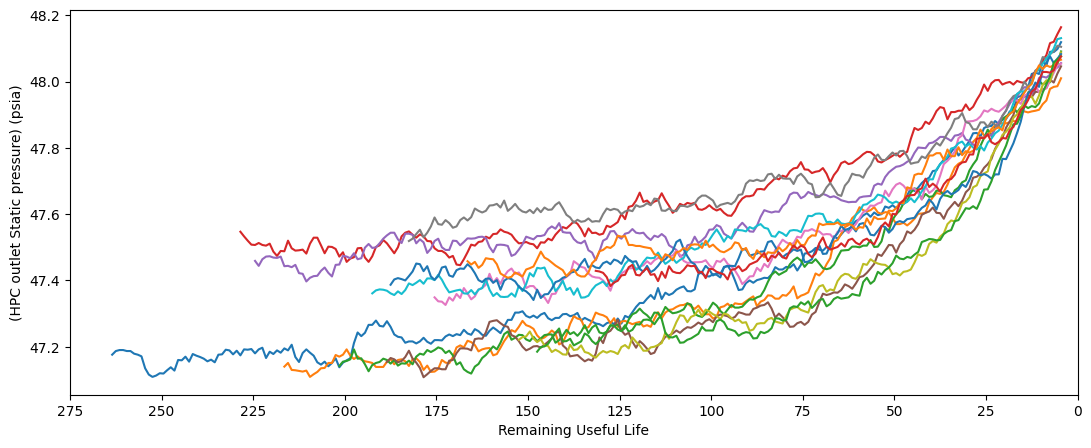

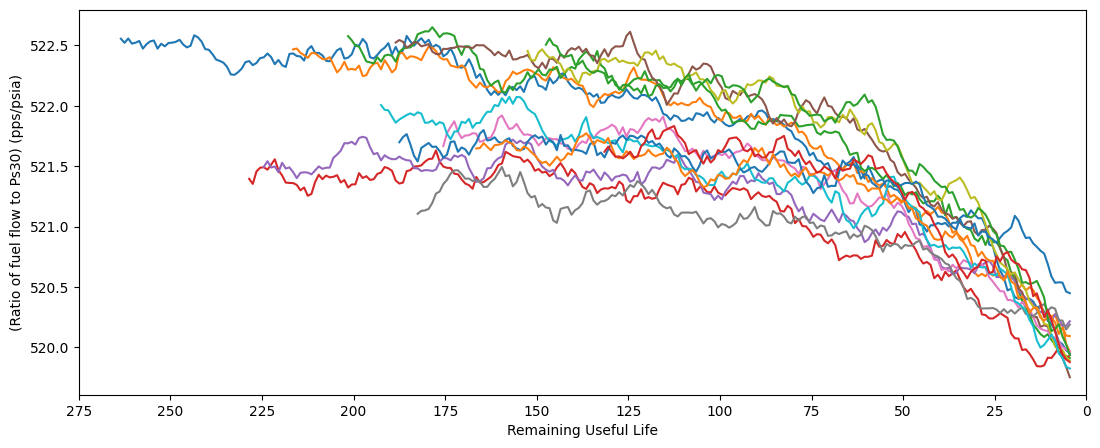

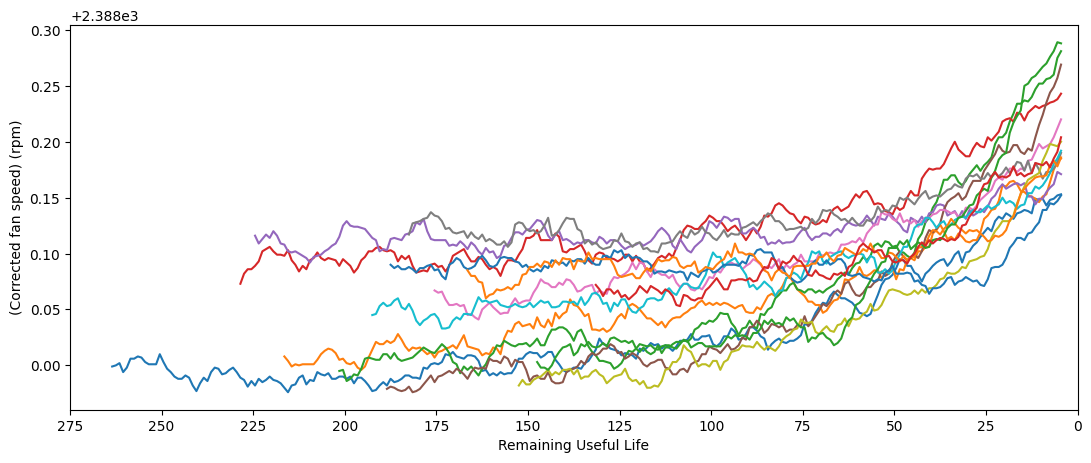

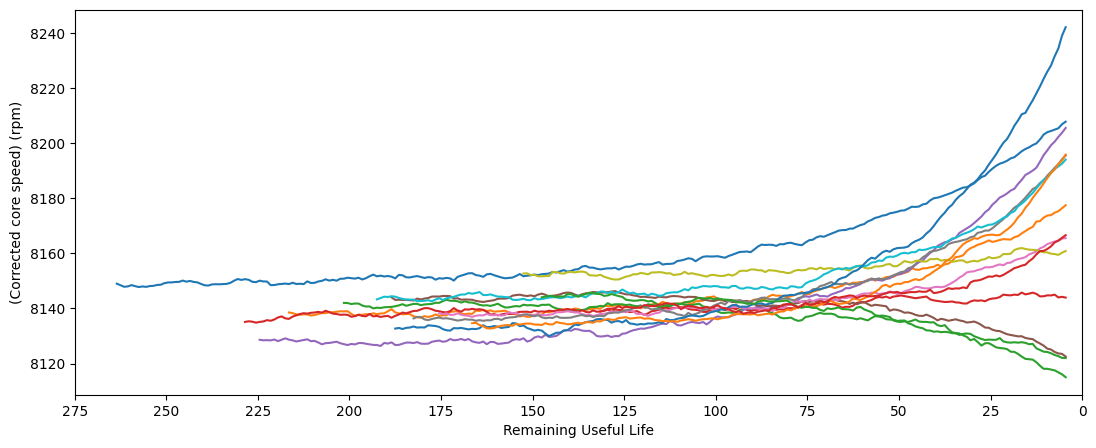

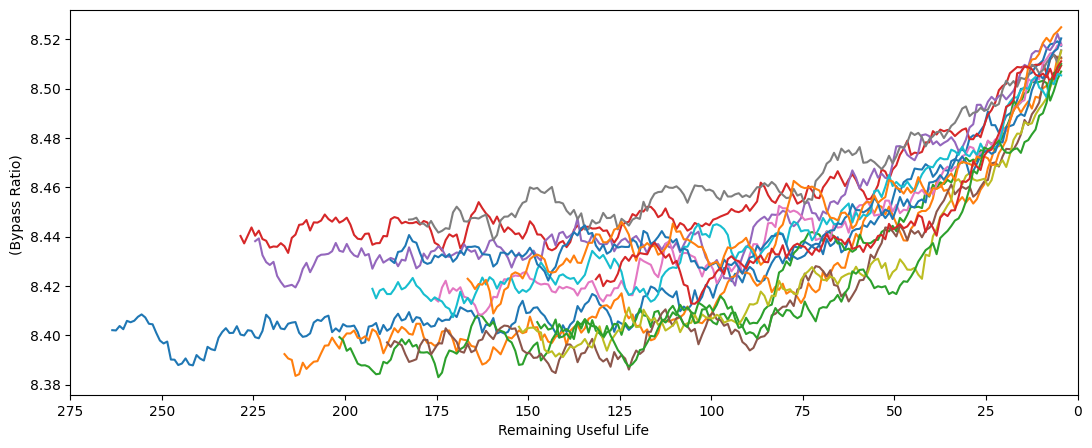

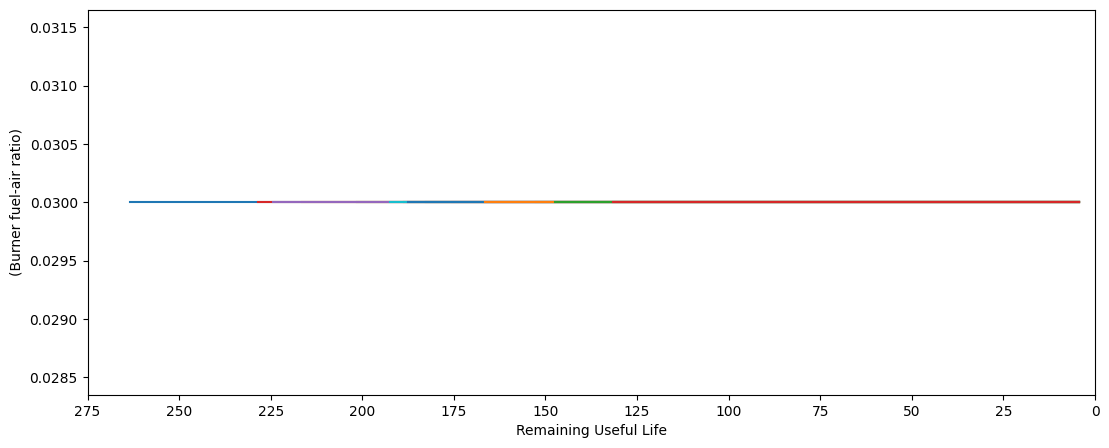

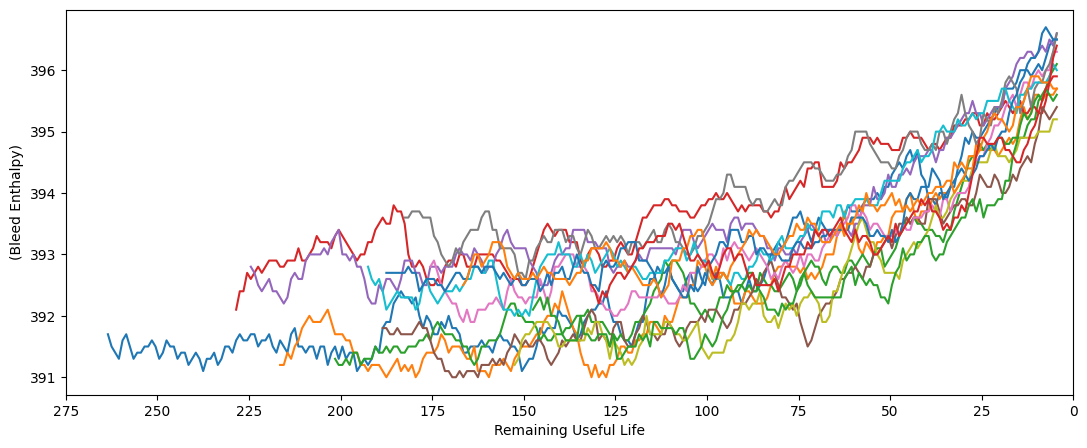

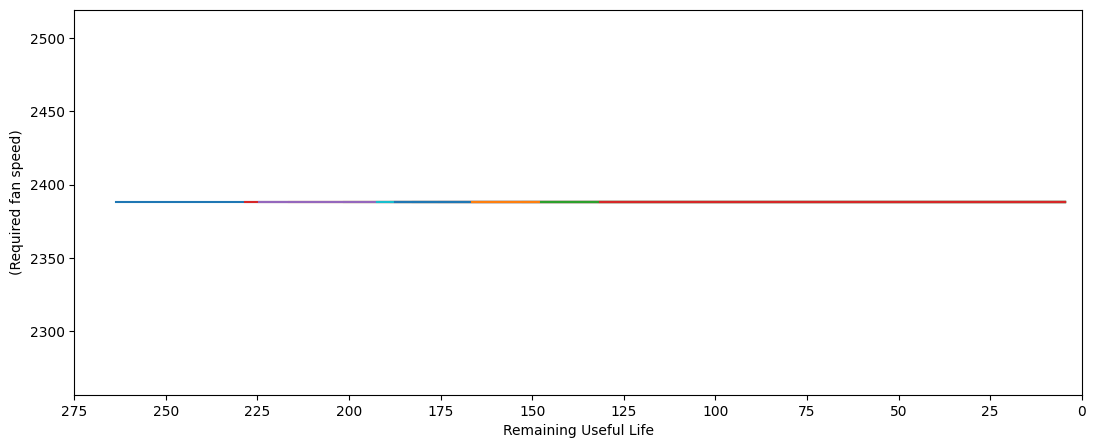

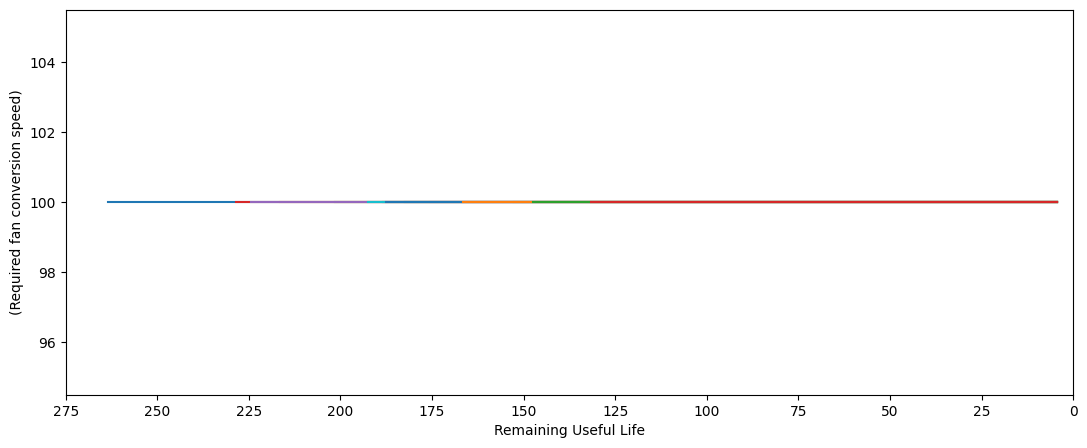

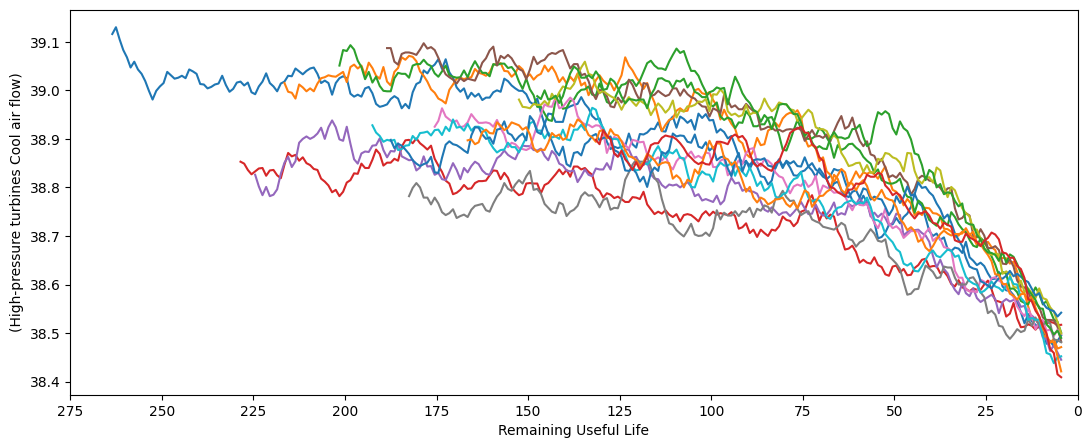

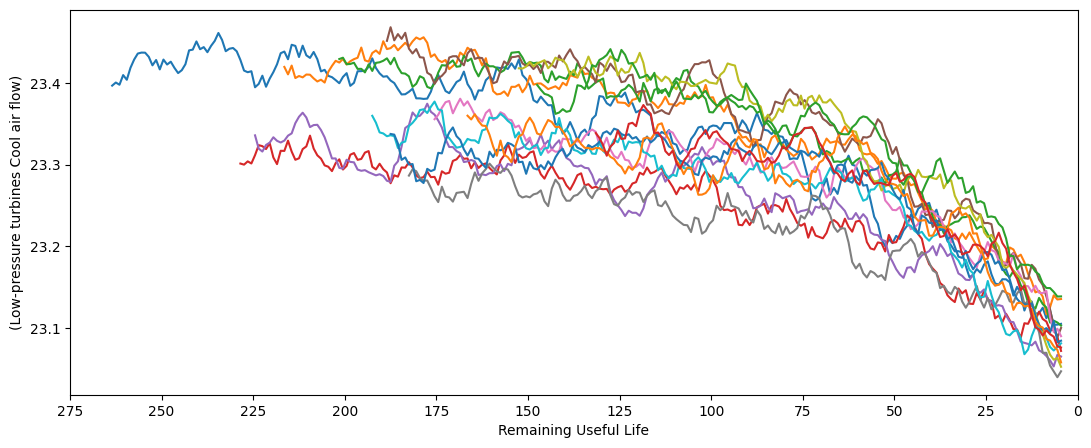

In [19]:
for i in range(1,22):
    try:
        plot_signal(train, Sensor_dictionary,'s_'+str(i))
    except:
        pass

In [20]:
train.loc[:,'s_1':].describe().transpose()

count         mean           std        min        25%         50%  \
s_1   14130.0   518.670000  0.000000e+00   518.6700   518.6700   518.67000   
s_2   14130.0   642.679557  5.023198e-01   641.2100   642.3200   642.64000   
s_3   14130.0  1590.525633  6.147556e+00  1571.0400  1586.2400  1590.10000   
s_4   14130.0  1408.863436  8.996052e+00  1386.4300  1402.2900  1407.94000   
s_5   14130.0    14.620000  3.552839e-15    14.6200    14.6200    14.62000   
s_6   14130.0    21.609793  1.422661e-03    21.6000    21.6100    21.61000   
s_7   14130.0   553.378678  8.892235e-01   549.8500   552.8100   553.45000   
s_8   14130.0  2388.094212  7.082073e-02  2387.9000  2388.0400  2388.09000   
s_9   14130.0  9066.736406  2.302779e+01  9021.7300  9054.0900  9061.52000   
s_10  14130.0     1.300000  2.220525e-16     1.3000     1.3000     1.30000   
s_11  14130.0    47.539013  2.677363e-01    46.8600    47.3400    47.51000   
s_12  14130.0   521.422984  7.379826e-01   518.6900   520.9600   521.49000   
s_13  14130.0  2388.093695  7.186739e-02  2387.8800  2388.0400  2388.09000   
s_14  14130.0  8145.134132  1.986630e+01  8102.8200  8134.3525  8141.45000   
s_15  14130.0     8.441998  3.756531e-02     8.3279     8.4147     8.43900   
s_16  14130.0     0.030000  1.040871e-17     0.0300     0.0300     0.03000   
s_17  14130.0   393.212810  1.556883e+00   388.0000   392.0000   393.00000   
s_18  14130.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.00000   
s_19  14130.0   100.000000  0.000000e+00   100.0000   100.0000   100.00000   
s_20  14130.0    38.817253  1.809565e-01    38.1600    38.7000    38.83000   
s_21  14130.0    23.290124  1.086214e-01    22.9071    23.2227    23.29805   
RUL   14130.0   105.003609  6.666673e+01     0.0000    50.0000   100.00000   

              75%        max  
s_1    518.670000   518.6700  
s_2    643.010000   644.5300  
s_3   1594.400000  1614.9300  
s_4   1414.510000  1441.4900  
s_5     14.620000    14.6200  
s_6     21.610000    21.6100  
s_7    554.030000   556.0600  
s_8   2388.140000  2388.5600  
s_9   9070.770000  9244.5900  
s_10     1.300000     1.3000  
s_11    47.700000    48.5300  
s_12   521.960000   523.3800  
s_13  2388.140000  2388.5600  
s_14  8149.510000  8293.7200  
s_15     8.465500     8.5848  
s_16     0.030000     0.0300  
s_17   394.000000   399.0000  
s_18  2388.000000  2388.0000  
s_19   100.000000   100.0000  
s_20    38.950000    39.4300  
s_21    23.367575    23.6127  
RUL    152.000000   361.0000

MinMax scaler function : Transform features by scaling each feature to a given range.

This estimater scales and translates each feature individually such that it is in the given range on the training set

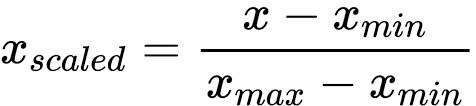

Dropping unnecessary features (labels and settings)

Scaling the data (Min-Max scaler)

In [21]:
def min_max_scaling(column):
    min_value = column.min()
    max_value = column.max()
    scaled_column = (column - min_value) / (max_value - min_value)

    # NaN 값을 0으로 바꿔줌
    scaled_column = scaled_column.fillna(0)

    return scaled_column

In [22]:
columns_to_scale = ['s_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21']
train[columns_to_scale] = train[columns_to_scale].apply(min_max_scaling, axis=0)
valid[columns_to_scale] = valid[columns_to_scale].apply(min_max_scaling, axis=0)
full_data[columns_to_scale] = full_data[columns_to_scale].apply(min_max_scaling, axis=0)

Test code

In [23]:
print(train)
print(valid)
print(full_data)

       unit_number  time_cycles  setting_1  setting_2  setting_3  s_1  \
0                1            1    -0.0007    -0.0004      100.0  0.0   
1                1            2     0.0019    -0.0003      100.0  0.0   
2                1            3    -0.0043     0.0003      100.0  0.0   
3                1            4     0.0007     0.0000      100.0  0.0   
4                1            5    -0.0019    -0.0002      100.0  0.0   
...            ...          ...        ...        ...        ...  ...   
14125           70          133    -0.0015    -0.0001      100.0  0.0   
14126           70          134    -0.0012    -0.0004      100.0  0.0   
14127           70          135     0.0004     0.0003      100.0  0.0   
14128           70          136    -0.0044     0.0000      100.0  0.0   
14129           70          137     0.0014    -0.0000      100.0  0.0   

            s_2       s_3       s_4  s_5  ...      s_13      s_14      s_15  \
0      0.183735  0.425154  0.257356  0.0  ..

# Model Implementation

**Linear regression**

# **Loss function Tuning**

**1. Original MSE**

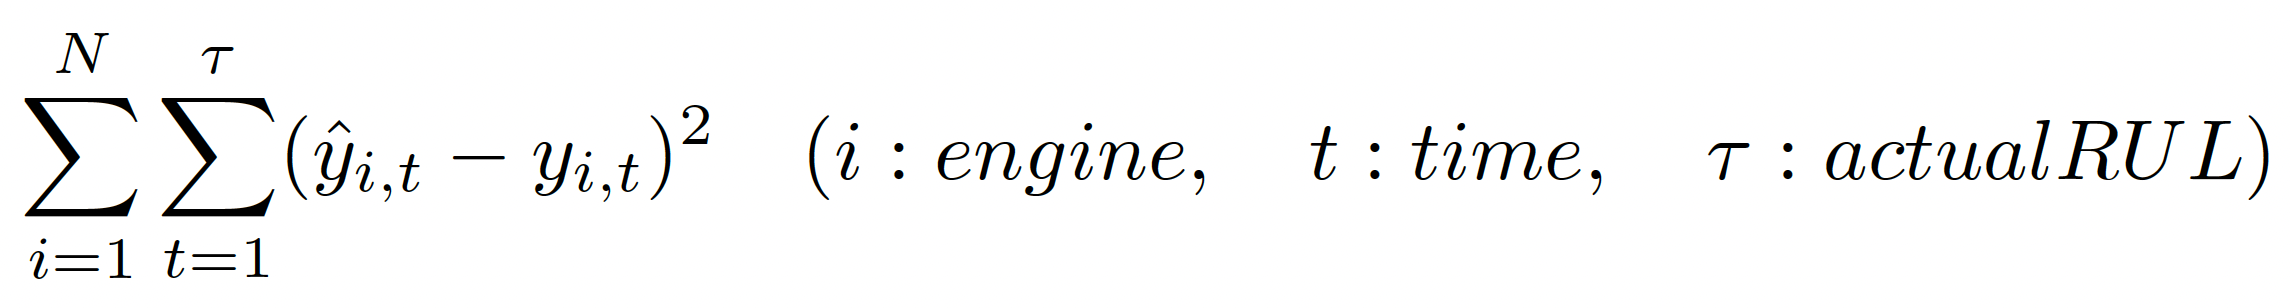

In [24]:
"""
# 1. Original Linear Regression (모든 데이터 사용)
lr1 = LinearRegression()

lr1.fit(X_train_1_s, y_train_clip) #Fitting

y_lr_train_1 = lr1.predict(X_train_1_s) #Prediction on train data

y_lr_valid_1 = lr1.predict(X_valid_1_s) #Prediction on validation data

y_lr_full_1 = lr1.predict(X_full_1_s) #Prediction on full data

print(lr1.coef_)
"""

'\n# 1. Original Linear Regression (모든 데이터 사용)\nlr1 = LinearRegression()\n\nlr1.fit(X_train_1_s, y_train_clip) #Fitting\n\ny_lr_train_1 = lr1.predict(X_train_1_s) #Prediction on train data\n\ny_lr_valid_1 = lr1.predict(X_valid_1_s) #Prediction on validation data\n\ny_lr_full_1 = lr1.predict(X_full_1_s) #Prediction on full data\n\nprint(lr1.coef_)\n'

**2. Crucial moments Loss function**

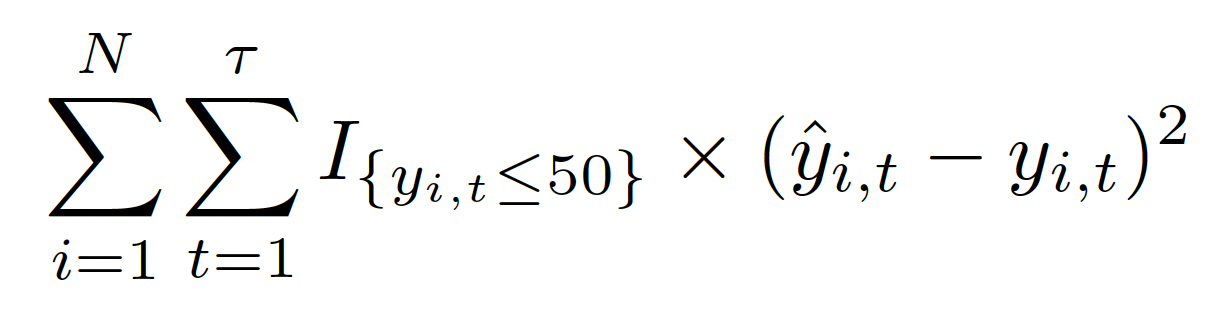

In [25]:
"""
# 2. Crucial moments loss function - Linear Regression

# Filter and save only data that is less than 50.
filtered_data = X_train_1_s[y_train_clip <= 50]
filtered_labels = y_train_clip[y_train_clip <= 50]

lr2 = LinearRegression()

lr2.fit(filtered_data, filtered_labels) #Fitting

y_lr_train_2 = lr2.predict(X_train_1_s) #Prediction on train data
evaluate(y_train_clip, y_lr_train_2, label='train')

y_lr_valid_2 = lr2.predict(X_valid_1_s) #Prediction on validation data
evaluate(y_valid, y_lr_valid_2, label='valid')

y_lr_full_2 = lr2.predict(X_full_1_s) #Prediction on full data
evaluate(y_full, y_lr_full_2, label='full data')

print(lr2.coef_)
"""

"\n# 2. Crucial moments loss function - Linear Regression\n\n# Filter and save only data that is less than 50.\nfiltered_data = X_train_1_s[y_train_clip <= 50]\nfiltered_labels = y_train_clip[y_train_clip <= 50]\n\nlr2 = LinearRegression()\n\nlr2.fit(filtered_data, filtered_labels) #Fitting\n\ny_lr_train_2 = lr2.predict(X_train_1_s) #Prediction on train data\nevaluate(y_train_clip, y_lr_train_2, label='train')\n\ny_lr_valid_2 = lr2.predict(X_valid_1_s) #Prediction on validation data\nevaluate(y_valid, y_lr_valid_2, label='valid')\n\ny_lr_full_2 = lr2.predict(X_full_1_s) #Prediction on full data\nevaluate(y_full, y_lr_full_2, label='full data')\n\nprint(lr2.coef_)\n"

**3. TD Style Loss function (ridge regression)**

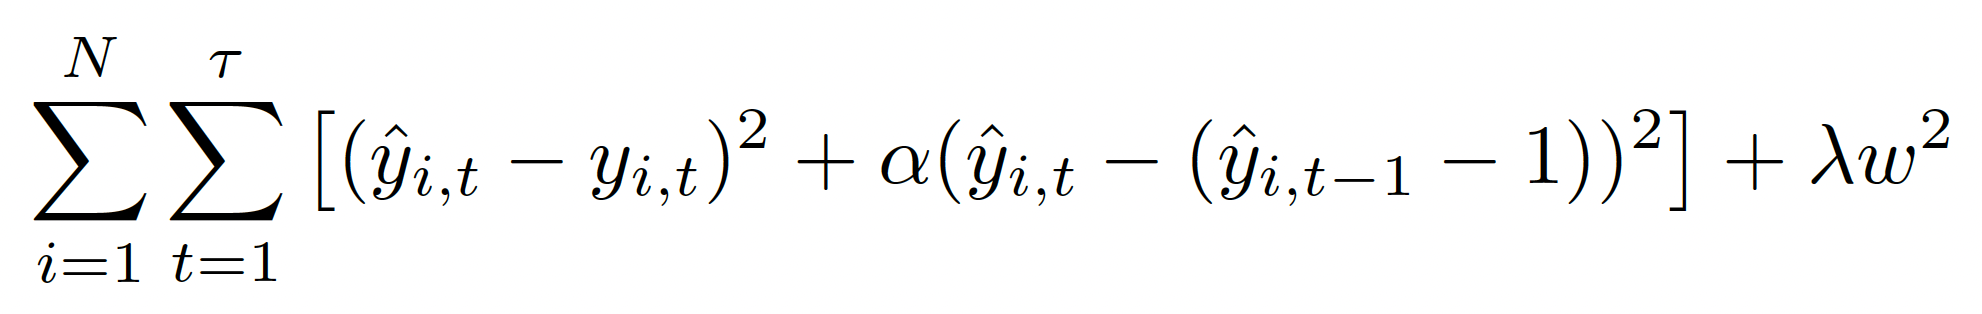

In [26]:
"""
# Multi var linear regression

class Linear_Regression_TD() :
  def __init__( self, alpha=0, lambda_ridge=0 ) :
    self.alpha = alpha
    self.lambda_ridge = lambda_ridge  # Ridge regression

  def fit(self, X, Y, alpha, lambd) :
    self.l, self.p = X.shape
    self.alpha = alpha
    self.lambda_ridge = lambd
    # weight initializer
    self.p = (self.p + 1)         # add constant term.

    self.add_X = np.ones(self.l)
    self.X = np.c_[self.add_X, X]

    self.array_Y = np.array(Y[0:].to_numpy())
    self.array_Y.reshape( self.l, 1 )
    self.Y = self.array_Y
    self.W = np.zeros( self.p ) # W : 0 (b is included)

    self.identity = np.identity( n = self.p ) # Ridge regression
    self.lambda_identity = self.lambda_ridge * self.identity   # lambda * I

    # 각각의 행렬 연산
    X_T_X = (self.X.T) @ (self.X)          # X^(T)X
    X_diff_T_X_diff_sum = np.zeros( [self.p, self.p] )

    for i in range(1, self.l):
      X_diff_T_X_diff = (( self.X[i, :] - self.X[i - 1, :] ).reshape(self.p, 1)) @ (( self.X[i, :] - self.X[i - 1, :] ).reshape(1, self.p))
      X_diff_T_X_diff_sum += X_diff_T_X_diff


    X_T_Y = (self.X.T) @ (self.Y)
    X_T_Y = X_T_Y.reshape( self.p, 1 )
    X_diff_T_sum = np.zeros( [self.p, 1] )

    for i in range(1, self.l):
      X_diff_T = (( self.X[i, :] - self.X[i - 1, :] ).reshape( self.p, 1 ))
      X_diff_T_sum += X_diff_T

    self.W = np.linalg.inv(X_T_X + (self.alpha * X_diff_T_X_diff_sum) + self.lambda_identity) @ (X_T_Y - self.alpha * X_diff_T_sum)

    print(self.W)
    print(self.W.shape)

# X를 입력 받으면 첫 열에 1의 값을 갖는 열을 추가해서 계산해야함. (입력으로 들어오는 X는 (n, 21)이니 (n, 22)로 바꿔줘야 함)
  def predict( self, X) :
    l_X, p_X = X.shape
    p_X = p_X + 1
    add_col = np.ones(l_X)

    X = np.c_[add_col, X]

    return X.dot( self.W )
"""

'\n# Multi var linear regression\n\nclass Linear_Regression_TD() :\n  def __init__( self, alpha=0, lambda_ridge=0 ) :\n    self.alpha = alpha\n    self.lambda_ridge = lambda_ridge  # Ridge regression\n\n  def fit(self, X, Y, alpha, lambd) :\n    self.l, self.p = X.shape\n    self.alpha = alpha\n    self.lambda_ridge = lambd\n    # weight initializer\n    self.p = (self.p + 1)         # add constant term.\n\n    self.add_X = np.ones(self.l)\n    self.X = np.c_[self.add_X, X]\n\n    self.array_Y = np.array(Y[0:].to_numpy())\n    self.array_Y.reshape( self.l, 1 )\n    self.Y = self.array_Y\n    self.W = np.zeros( self.p ) # W : 0 (b is included)\n\n    self.identity = np.identity( n = self.p ) # Ridge regression\n    self.lambda_identity = self.lambda_ridge * self.identity   # lambda * I\n\n    # 각각의 행렬 연산\n    X_T_X = (self.X.T) @ (self.X)          # X^(T)X\n    X_diff_T_X_diff_sum = np.zeros( [self.p, self.p] )\n\n    for i in range(1, self.l):\n      X_diff_T_X_diff = (( self.X[i, :] -

In [27]:
"""
lr3 = Linear_Regression_TD()

# fit(X, Y, alpha, lambda)        # lambda = 10
lr3.fit(X_train_1_s, y_train_clip, 0.5, 10) #Fitting

y_lr_train_3 = lr3.predict(X_train_1_s) #Prediction on train data

y_lr_valid_3 = lr3.predict(X_valid_1_s) #Prediction on validation data

y_lr_full_3 = lr3.predict(X_full_1_s) #Prediction on full data
"""

'\nlr3 = Linear_Regression_TD()\n\n# fit(X, Y, alpha, lambda)        # lambda = 10\nlr3.fit(X_train_1_s, y_train_clip, 0.5, 10) #Fitting\n\ny_lr_train_3 = lr3.predict(X_train_1_s) #Prediction on train data\n\ny_lr_valid_3 = lr3.predict(X_valid_1_s) #Prediction on validation data\n\ny_lr_full_3 = lr3.predict(X_full_1_s) #Prediction on full data\n'

**4. TD Style Loss function + Crucial moments (ridge regression)**

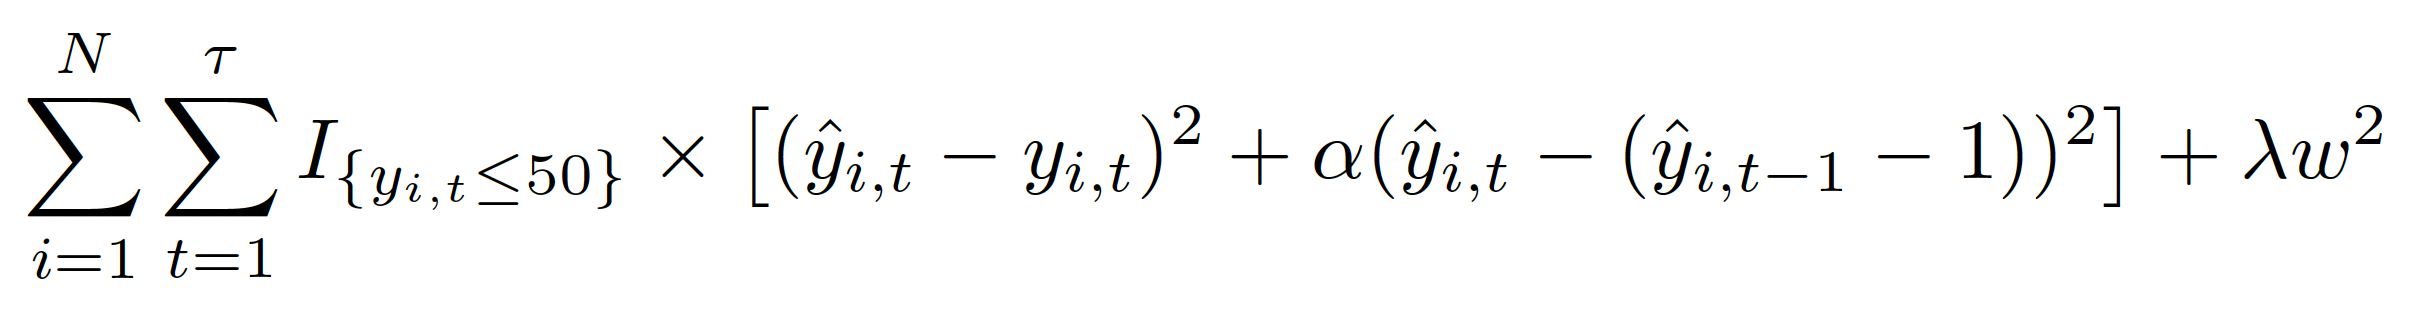

In [28]:
"""
filtered_data_2 = X_train_1_s[y_train_clip <= 50]
filtered_labels_2 = y_train_clip[y_train_clip <= 50]

lr4 = Linear_Regression_TD()

# fit(X, Y, alpha, lambda)        # lambda = 10
lr4.fit(filtered_data_2, filtered_labels_2, 0.5, 10) #Fitting

y_lr_train_4 = lr4.predict(X_train_1_s)
evaluate(y_train_clip, y_lr_train_4, label='train')

y_lr_valid_4 = lr4.predict(X_valid_1_s) #Prediction on validation data
evaluate(y_valid, y_lr_valid_4, label='valid')

y_lr_full_4 = lr4.predict(X_full_1_s) #Prediction on full data
evaluate(y_full, y_lr_full_4, label='full data')
"""

"\nfiltered_data_2 = X_train_1_s[y_train_clip <= 50]\nfiltered_labels_2 = y_train_clip[y_train_clip <= 50]\n\nlr4 = Linear_Regression_TD()\n\n# fit(X, Y, alpha, lambda)        # lambda = 10\nlr4.fit(filtered_data_2, filtered_labels_2, 0.5, 10) #Fitting\n\ny_lr_train_4 = lr4.predict(X_train_1_s)\nevaluate(y_train_clip, y_lr_train_4, label='train')\n\ny_lr_valid_4 = lr4.predict(X_valid_1_s) #Prediction on validation data\nevaluate(y_valid, y_lr_valid_4, label='valid')\n\ny_lr_full_4 = lr4.predict(X_full_1_s) #Prediction on full data\nevaluate(y_full, y_lr_full_4, label='full data')\n"

# What is the best policy parameter?


**Experiment 1 - Gaussian Smoothing**

(Dataset 1, Loss function 1, Theta = 0)

In [29]:
"""
# Importing the library for using the 'deepcopy' method.
import copy

# Through the 'deepcopy' method, I assigned different addresses to lr1 and lr5, making them independent objects.
lr5 = copy.deepcopy(lr1)   # loss function 1의 w,b를 lr5에 저장 (가장 안좋은 parameter를 보고 학습 과정을 지켜보기 위함)
threshold_theta = 0       # initial theta = 10

# Hyper Parameter
GS_lr = 0.0001                  # learning rate
sd = 0.01                      # standard deviation
num_of_epsilon = 7              # for expectation -> mean(epsilon 1, epsilon 2, ... , epsilon n)

# 패널티 텀에 의한 영향을 잠시 제거 (값을 낮춰서)
coef_of_MSE_w = 0.00001         # penalty term of MSE(W)
coef_of_MSE_b = 0.000001         # penalty term of MSE(b)
coef_of_MSE_theta = 0.000001      # penalty term of MSE(theta)


# save initial parameter (for calculate MSE)
initial_parameter = copy.deepcopy(lr5)
initial_theta = threshold_theta

# print
print(lr5.coef_)          # coef_ : w (21-dim)
print(lr5.intercept_)     # intercept_ : b (1-dim)
print(threshold_theta)
"""

"\n# Importing the library for using the 'deepcopy' method.\nimport copy\n\n# Through the 'deepcopy' method, I assigned different addresses to lr1 and lr5, making them independent objects.\nlr5 = copy.deepcopy(lr1)   # loss function 1의 w,b를 lr5에 저장 (가장 안좋은 parameter를 보고 학습 과정을 지켜보기 위함)\nthreshold_theta = 0       # initial theta = 10\n\n# Hyper Parameter\nGS_lr = 0.0001                  # learning rate\nsd = 0.01                      # standard deviation\nnum_of_epsilon = 7              # for expectation -> mean(epsilon 1, epsilon 2, ... , epsilon n)\n\n# 패널티 텀에 의한 영향을 잠시 제거 (값을 낮춰서)\ncoef_of_MSE_w = 0.00001         # penalty term of MSE(W)\ncoef_of_MSE_b = 0.000001         # penalty term of MSE(b)\ncoef_of_MSE_theta = 0.000001      # penalty term of MSE(theta)\n\n\n# save initial parameter (for calculate MSE)\ninitial_parameter = copy.deepcopy(lr5)\ninitial_theta = threshold_theta\n\n# print\nprint(lr5.coef_)          # coef_ : w (21-dim)\nprint(lr5.intercept_)     # intercept_ : b (1-

Scalar 값을 입력으로 받는 MSE 함수 정의

In [30]:
"""
def mean_squared_error_scalar(y_true, y_pred):
    mse = (y_true - y_pred) ** 2
    return mse
"""

'\ndef mean_squared_error_scalar(y_true, y_pred):\n    mse = (y_true - y_pred) ** 2\n    return mse\n'

In [31]:
# test code
"""
print(( GS_lr * ( ( gradient_w / (sd ** 2) ) + coef_of_MSE_w * (initial_parameter.coef_ - lr5.coef_) ) ))
print(( GS_lr * ( ( gradient_b / (sd ** 2)) + coef_of_MSE_b * (initial_parameter.intercept_ - lr5.intercept_) ) ))
print(( GS_lr * ( ( gradient_theta / (sd ** 2) ) + coef_of_MSE_theta * (initial_theta - threshold_theta) ) ))

print( GS_lr * ( ( gradient_w / (sd ** 2))))
print( GS_lr * ( ( gradient_b / (sd ** 2))))
print( GS_lr * ( ( gradient_theta / (sd ** 2))))
"""

'\nprint(( GS_lr * ( ( gradient_w / (sd ** 2) ) + coef_of_MSE_w * (initial_parameter.coef_ - lr5.coef_) ) ))\nprint(( GS_lr * ( ( gradient_b / (sd ** 2)) + coef_of_MSE_b * (initial_parameter.intercept_ - lr5.intercept_) ) ))\nprint(( GS_lr * ( ( gradient_theta / (sd ** 2) ) + coef_of_MSE_theta * (initial_theta - threshold_theta) ) ))\n\nprint( GS_lr * ( ( gradient_w / (sd ** 2))))\nprint( GS_lr * ( ( gradient_b / (sd ** 2))))\nprint( GS_lr * ( ( gradient_theta / (sd ** 2))))\n'

In [32]:
"""
## 'Epsilon 여러개 뽑는 version' + 'penalty term'으로 convergence 안정화 ##

# Initialize the DataFrame to store results
simul_result_df = pd.DataFrame(columns=['W', 'b', 'Theta', 'Average usage time', 'Average cost', 'Number of failure'])

# Define the number of iterations (n)
n = 6000  # Change this to the desired number of iterations

for i in range(n):
    # Epsilon ~ N(0,0.1)
    epsilon_w = np.mean([np.random.normal(0, sd, 21) for _ in range(num_of_epsilon)], axis=0)
    epsilon_b = np.mean([np.random.normal(0, sd, 1) for _ in range(num_of_epsilon)])
    epsilon_theta = np.mean([np.random.normal(0, sd, 1) for _ in range(num_of_epsilon)])

    lr5.coef_ += epsilon_w
    lr5.intercept_ += epsilon_b
    threshold_theta += epsilon_theta

    y_full_prediction = lr5.predict(X_full_1_s)

    # Merge dataframe (label + data)
    y_full_prediction_df = pd.DataFrame(y_full_prediction, columns=['predicted RUL'])
    merged_full_prediction_df = pd.concat([X_full_index_names, y_full_prediction_df, y_full], axis=1)

    cumulative_operation_time = 0
    total_cost = 0
    average_cost = 0

    by_threshold_full_prediction_df = pd.DataFrame(columns=['unit_number', 'actual operation time', 'actual RUL', 'Cumulative Operation Time', 'Total Cost'])
    grouped = merged_full_prediction_df.groupby('unit_number')

    for unit, group in grouped:
        operation_time = None
        max_RUL = group['RUL'].max()

        for index, row in group.iterrows():
            if row['predicted RUL'] <= threshold_theta:
                operation_time = row['time_cycles']
                cumulative_operation_time += operation_time
                total_cost += REPLACE_COST
                break

        if pd.isna(operation_time):
            cumulative_operation_time += max_RUL
            total_cost += FAILURE_COST

        average_cost = (total_cost / cumulative_operation_time)
        by_threshold_full_prediction_df = by_threshold_full_prediction_df.append({'unit_number': unit, 'actual operation time': operation_time,
                                                                                  'actual RUL': max_RUL, 'Cumulative Operation Time': cumulative_operation_time,
                                                                                  'Average Cost' : average_cost, 'Total Cost': total_cost}, ignore_index=True)

    simul_average_usage_time = by_threshold_full_prediction_df['Cumulative Operation Time'].iloc[-1] / (len(by_threshold_full_prediction_df.index) + 1)
    simul_average_cost_by_threshold = by_threshold_full_prediction_df['Average Cost'].iloc[-1]
    simul_nan_count = by_threshold_full_prediction_df.loc[:, 'actual operation time'].isna().sum()

    # 앞에서 넣은 epsilon을 다시 제거하고, 원래의 parameter로 되돌림.
    lr5.coef_ -= epsilon_w
    lr5.intercept_ -= epsilon_b
    threshold_theta -= epsilon_theta

    # Expectation 내의 gradient 부분만 계산
    gradient_w = simul_average_cost_by_threshold * epsilon_w          # "f(w+eps, b+eps, theta+eps) * [ epsilon vector ]"에서 w 부분
    gradient_b = simul_average_cost_by_threshold * epsilon_b          # b 부분
    gradient_theta = simul_average_cost_by_threshold * epsilon_theta  # theta 부분


    # test code
    #print(( GS_lr * ( ( gradient_w / (sd ** 2) ) + coef_of_MSE_w * (initial_parameter.coef_ - lr5.coef_) ) ))
    #print(( GS_lr * ( ( gradient_b / (sd ** 2)) + coef_of_MSE_b * (initial_parameter.intercept_ - lr5.intercept_) ) ))
    #print(( GS_lr * ( ( gradient_theta / (sd ** 2) ) + coef_of_MSE_theta * (initial_theta - threshold_theta) ) ))

    #print( GS_lr * ( ( gradient_w / (sd ** 2))))
    #print( GS_lr * ( ( gradient_b / (sd ** 2))))
    #print( GS_lr * ( ( gradient_theta / (sd ** 2))))


    # [W,b,theta] update  # 여기에 MSE penalty를 넣어줘야 함.
    lr5.coef_ -= ( GS_lr * ( ( gradient_w / (sd ** 2) ) + coef_of_MSE_w * (initial_parameter.coef_ - lr5.coef_) ) )
    lr5.intercept_ -= ( GS_lr * ( ( gradient_b / (sd ** 2)) + coef_of_MSE_b * (initial_parameter.intercept_ - lr5.intercept_) ) )
    threshold_theta -= ( GS_lr * ( ( gradient_theta / (sd ** 2) ) + coef_of_MSE_theta * (initial_theta - threshold_theta) ) )

    # Append the results to the DataFrame
    simul_result_df = simul_result_df.append({'Iteration' : i + 1, 'W': lr5.coef_.tolist(), 'b': lr5.intercept_.item(), 'Theta': threshold_theta.item(),
                                              'Average usage time': simul_average_usage_time, 'Average cost': simul_average_cost_by_threshold,
                                              'Number of failure': simul_nan_count}, ignore_index=True)

    print("Iteration : ", i + 1, "Average usage time : ", "{:.3f}".format(simul_average_usage_time),
          ", Average cost : ", "{:.3f}".format(simul_average_cost_by_threshold), ", Number of failures : ", simul_nan_count )
"""

'\n## \'Epsilon 여러개 뽑는 version\' + \'penalty term\'으로 convergence 안정화 ##\n\n# Initialize the DataFrame to store results\nsimul_result_df = pd.DataFrame(columns=[\'W\', \'b\', \'Theta\', \'Average usage time\', \'Average cost\', \'Number of failure\'])\n\n# Define the number of iterations (n)\nn = 6000  # Change this to the desired number of iterations\n\nfor i in range(n):\n    # Epsilon ~ N(0,0.1)\n    epsilon_w = np.mean([np.random.normal(0, sd, 21) for _ in range(num_of_epsilon)], axis=0)\n    epsilon_b = np.mean([np.random.normal(0, sd, 1) for _ in range(num_of_epsilon)])\n    epsilon_theta = np.mean([np.random.normal(0, sd, 1) for _ in range(num_of_epsilon)])\n\n    lr5.coef_ += epsilon_w\n    lr5.intercept_ += epsilon_b\n    threshold_theta += epsilon_theta\n\n    y_full_prediction = lr5.predict(X_full_1_s)\n\n    # Merge dataframe (label + data)\n    y_full_prediction_df = pd.DataFrame(y_full_prediction, columns=[\'predicted RUL\'])\n    merged_full_prediction_df = pd.concat([X_

In [33]:
"""
# Print or use the simul_result_df as needed
print(simul_result_df)
"""

'\n# Print or use the simul_result_df as needed\nprint(simul_result_df)\n'

In [34]:
"""
# Find optimal parameter
optimal_average_cost_row = simul_result_df.iloc[simul_result_df['Average cost'].idxmin()]
print(optimal_average_cost_row)
"""

"\n# Find optimal parameter\noptimal_average_cost_row = simul_result_df.iloc[simul_result_df['Average cost'].idxmin()]\nprint(optimal_average_cost_row)\n"

In [35]:
#optimal_average_cost_row['W']

In [36]:
#optimal_average_cost_row = simul_result_df.iloc[0]
#optimal_average_cost_row['W']

**Loss Plot**

In [37]:
"""
plt.figure(figsize=(10, 6))

# 'Iteration'을 x축으로, 'Average cost'을 y축으로 하는 그래프 그리기
plt.plot(simul_result_df['Iteration'], simul_result_df['Average cost'],
         marker='o', color='b', alpha=0.5)

# 그래프에 레이블 추가
plt.xlabel('Iteration')
plt.ylabel('Average cost')
plt.title('Results')

#plt.ylim(4.95, 10)
#plt.xlim(0, 1500)

# 그래프 표시
#plt.grid(True)  # 그리드 추가
plt.show()
"""

"\nplt.figure(figsize=(10, 6))\n\n# 'Iteration'을 x축으로, 'Average cost'을 y축으로 하는 그래프 그리기\nplt.plot(simul_result_df['Iteration'], simul_result_df['Average cost'],\n         marker='o', color='b', alpha=0.5)\n\n# 그래프에 레이블 추가\nplt.xlabel('Iteration')\nplt.ylabel('Average cost')\nplt.title('Results')\n\n#plt.ylim(4.95, 10)\n#plt.xlim(0, 1500)\n\n# 그래프 표시\n#plt.grid(True)  # 그리드 추가\nplt.show()\n"

**Plot에 optimal point 찍어보기**

"Optimal parameter로 성능 재현"

In [38]:
"""
#optimal_parameter = simul_result_df.iloc[213]    # optimal row
optimal_parameter = optimal_average_cost_row  # optimal row
optimal_w = np.array(optimal_parameter['W'])     # optimal paramter에서 W 추출
optimal_b = optimal_parameter['b']     # optimal paramter에서 b 추출
optimal_theta = optimal_parameter['Theta'] # optimal paramter에서 Theta

lr5.coef_ = optimal_w
lr5.intercept_ = optimal_b
threshold_theta = optimal_theta

y_optimal_prediction = lr5.predict(X_full_1_s)

 # Merge dataframe (label + data)
y_optimal_prediction_df = pd.DataFrame(y_optimal_prediction, columns=['predicted RUL'])
merged_optimal_prediction_df = pd.concat([X_full_index_names, y_optimal_prediction_df, y_full], axis=1)

cumulative_operation_time = 0
total_cost = 0
average_cost = 0


by_threshold_optimal_prediction_df = pd.DataFrame(columns=['unit_number', 'actual operation time', 'actual RUL', 'Cumulative Operation Time', 'Total Cost'])
grouped = merged_optimal_prediction_df.groupby('unit_number')

for unit, group in grouped:
    operation_time = None
    max_RUL = group['RUL'].max()

    for index, row in group.iterrows():
        if row['predicted RUL'] <= threshold_theta:
            operation_time = row['time_cycles']
            cumulative_operation_time += operation_time
            total_cost += REPLACE_COST
            break

    if pd.isna(operation_time):
        cumulative_operation_time += max_RUL
        total_cost += FAILURE_COST

    average_cost = (total_cost / cumulative_operation_time)
    by_threshold_optimal_prediction_df = by_threshold_optimal_prediction_df.append({'unit_number': unit, 'actual operation time': operation_time,
                                                                              'actual RUL': max_RUL, 'Cumulative Operation Time': cumulative_operation_time,
                                                                              'Average Cost' : average_cost, 'Total Cost': total_cost}, ignore_index=True)

optimal_average_usage_time = by_threshold_optimal_prediction_df['Cumulative Operation Time'].iloc[-1] / (len(by_threshold_optimal_prediction_df.index) + 1)
optimal_average_cost_by_threshold = by_threshold_optimal_prediction_df['Average Cost'].iloc[-1]
optimal_number_of_failure = by_threshold_optimal_prediction_df.loc[:, 'actual operation time'].isna().sum()


print("Optimal : ", "Average usage time : ", "{:.3f}".format(optimal_average_usage_time),
      ", Average cost : ", "{:.3f}".format(optimal_average_cost_by_threshold), ", Number of failures : ", optimal_number_of_failure )
"""

'\n#optimal_parameter = simul_result_df.iloc[213]    # optimal row\noptimal_parameter = optimal_average_cost_row  # optimal row\noptimal_w = np.array(optimal_parameter[\'W\'])     # optimal paramter에서 W 추출\noptimal_b = optimal_parameter[\'b\']     # optimal paramter에서 b 추출\noptimal_theta = optimal_parameter[\'Theta\'] # optimal paramter에서 Theta\n\nlr5.coef_ = optimal_w\nlr5.intercept_ = optimal_b\nthreshold_theta = optimal_theta\n\ny_optimal_prediction = lr5.predict(X_full_1_s)\n\n # Merge dataframe (label + data)\ny_optimal_prediction_df = pd.DataFrame(y_optimal_prediction, columns=[\'predicted RUL\'])\nmerged_optimal_prediction_df = pd.concat([X_full_index_names, y_optimal_prediction_df, y_full], axis=1)\n\ncumulative_operation_time = 0\ntotal_cost = 0\naverage_cost = 0\n\n\nby_threshold_optimal_prediction_df = pd.DataFrame(columns=[\'unit_number\', \'actual operation time\', \'actual RUL\', \'Cumulative Operation Time\', \'Total Cost\'])\ngrouped = merged_optimal_prediction_df.group

In [39]:
"""
# Create a list of colors for each dataframe
colors = ['blue', 'green', 'red', 'yellow']

fig, ax = plt.subplots(figsize=(6, 6))

# Loop through the dataframes and plot scatter points with different colors
for i, full_nan_counts_and_cost_df in enumerate(full_nan_counts_and_cost_df_list):
    ax.plot(
        full_nan_counts_and_cost_df['Number of replace failures'],
        full_nan_counts_and_cost_df['Average usage time'], '+-',
        label=f'Loss function {i + 1}',
        color=colors[i],
        alpha=0.5
    )

# Set labels and title
ax.set_xlabel('Number of replace failures')
ax.set_ylabel('Average usage time')
ax.set_title('Number of Failures vs. Average usage time (Dataset 1)')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 2)')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 3)')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 4)')

# Add legend
ax.legend()

# Set integer ticks for y-axes
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_ylim(191,203) ### for dataset1
#ax.set_ylim(172,205) ### for dataset2
#ax.set_ylim(226,240) ### for dataset3
#ax.set_ylim(190,237) ### for dataset4
ax.set_xlim(-0.5,15)

# Set aspect ratio to make the plot square
#ax.set_aspect('equal')


###########################################################################################

optimal_x = optimal_number_of_failure
optimal_y = optimal_average_usage_time

# Plot a point using the extracted values
ax.plot(
    optimal_x,
    optimal_y,
    'ro',  # 'ro'는 빨간색 원형 점.
    label='Optimal Point'
)
###########################################################################################

# Show the plot
plt.tight_layout()
plt.show()
"""

"\n# Create a list of colors for each dataframe\ncolors = ['blue', 'green', 'red', 'yellow']\n\nfig, ax = plt.subplots(figsize=(6, 6))\n\n# Loop through the dataframes and plot scatter points with different colors\nfor i, full_nan_counts_and_cost_df in enumerate(full_nan_counts_and_cost_df_list):\n    ax.plot(\n        full_nan_counts_and_cost_df['Number of replace failures'],\n        full_nan_counts_and_cost_df['Average usage time'], '+-',\n        label=f'Loss function {i + 1}',\n        color=colors[i],\n        alpha=0.5\n    )\n\n# Set labels and title\nax.set_xlabel('Number of replace failures')\nax.set_ylabel('Average usage time')\nax.set_title('Number of Failures vs. Average usage time (Dataset 1)')\n#ax.set_title('Number of Failures vs. Average usage time (Dataset 2)')\n#ax.set_title('Number of Failures vs. Average usage time (Dataset 3)')\n#ax.set_title('Number of Failures vs. Average usage time (Dataset 4)')\n\n# Add legend\nax.legend()\n\n# Set integer ticks for y-axes\nax

In [40]:
# epsilon이 포함된 상태에서의 optimal NoF와 Average usage time (실제 저장된 w,b,theta를 이용한 값이 아님)
"""
# Create a list of colors for each dataframe
colors = ['blue', 'green', 'red', 'yellow']

fig, ax = plt.subplots(figsize=(6, 6))

# Loop through the dataframes and plot scatter points with different colors
for i, full_nan_counts_and_cost_df in enumerate(full_nan_counts_and_cost_df_list):
    ax.plot(
        full_nan_counts_and_cost_df['Number of replace failures'],
        full_nan_counts_and_cost_df['Average usage time'], '+-',
        label=f'Loss function {i + 1}',
        color=colors[i],
        alpha=0.5
    )

# Set labels and title
ax.set_xlabel('Number of replace failures')
ax.set_ylabel('Average usage time')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 1)')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 2)')
ax.set_title('Number of Failures vs. Average usage time (Dataset 3)')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 4)')

# Add legend
ax.legend()

# Set integer ticks for y-axes
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

#ax.set_ylim(191,203) ### for dataset1
#ax.set_ylim(172,205) ### for dataset2
ax.set_ylim(226,240) ### for dataset3
#ax.set_ylim(190,237) ### for dataset4
ax.set_xlim(-0.5,15)

# Set aspect ratio to make the plot square
#ax.set_aspect('equal')

###########################################################################################
# Extract data from a specific row of result_df (e.g., row 50)
optimal_point_row = simul_result_df.iloc[213]  # Change the index to the desired row number

optimal_x = optimal_point_row['Number of failure']
optimal_y = optimal_point_row['Average usage time']

# Plot a point using the extracted values
ax.plot(
    optimal_x,
    optimal_y,
    'ro',  # 'ro'는 빨간색 원형 점.
    label='Optimal Point'
)
###########################################################################################

# Show the plot
plt.tight_layout()
plt.show()
"""

"\n# Create a list of colors for each dataframe\ncolors = ['blue', 'green', 'red', 'yellow']\n\nfig, ax = plt.subplots(figsize=(6, 6))\n\n# Loop through the dataframes and plot scatter points with different colors\nfor i, full_nan_counts_and_cost_df in enumerate(full_nan_counts_and_cost_df_list):\n    ax.plot(\n        full_nan_counts_and_cost_df['Number of replace failures'],\n        full_nan_counts_and_cost_df['Average usage time'], '+-',\n        label=f'Loss function {i + 1}',\n        color=colors[i],\n        alpha=0.5\n    )\n\n# Set labels and title\nax.set_xlabel('Number of replace failures')\nax.set_ylabel('Average usage time')\n#ax.set_title('Number of Failures vs. Average usage time (Dataset 1)')\n#ax.set_title('Number of Failures vs. Average usage time (Dataset 2)')\nax.set_title('Number of Failures vs. Average usage time (Dataset 3)')\n#ax.set_title('Number of Failures vs. Average usage time (Dataset 4)')\n\n# Add legend\nax.legend()\n\n# Set integer ticks for y-axes\nax

# **Value-based RL**

In [41]:
# 우선 1~70까지의 Engine으로 학습을 진행하고, 71~100의 30개 엔진으로 테스트.
# T_N : The total operation time of N engines using a threshold policy

# Unit(engine)의 replace, 고장 -> 다음 unit으로 넘어가도록 구현 (순차적으로 넘어가도록, 아직 randomize는 적용 x)
# Unit을 변경하며 cumulative reward의 최대화 수행.

# Q_continue, Q_replace를 따로 구한 후 action을 선택하도록 구현.
# Q-function은 linear function으로 만들어줘야 함 (Linear VFA로 구현?).

# Q-value가 나타내는 것은 미래의 cost (discount factor gamma가 1이 되면, 우리가 보는 문제와 같아짐)
# 얻어지는 Q-value와 앞서 다룬 f는 1:1 대응은 아닐 것. 아마 'Q / (1-gamma)'를 f와 비교해볼 수 있지 않을까.

# q^ (s,a,w) ~~ q_ㅠ(s,a)
# update parameter w using MC or TD learning.

# Environment

In [42]:
from copy import copy
# epsilon을 지수형태로 바꿔서 해보자. (우선 아래 세팅부터)
gamma = 0.999   # discount factor
alpha = 0.0025    # learning rate
initial_epsilon = 1.0      # epsilon-greedy에서 initial epsilon 값.
epsilon_delta = 0.00025     # epsilon 감소량 (실제로 학습시킬 때, Max episode에 맞게 조절하자. linear로 떨어지도록)
min_epsilon = 0.0001         # 최소 epsilon (epsilon greedy algorithm)
max_episodes = 100   # 전체 데이터 셋에 대한 학습 횟수.

In [43]:
environment = train                                # environment는 train dataset.
max_unit_number = environment['unit_number'].max() # 마지막 unit_number를 return. (1~70이라면 70 반환)

# train에서 state들 분리 (s_1, s_2, ... , s_21)
# state set 정의
states = environment[['s_{}'.format(i) for i in range(1, 22)]]

# action 정의
actions = ["continue", "replace"]

# 각 action(continue, relpace)에 대한 weight (Linear Function Approximation; LFA)
# action 각각에 대한 Q-function을 학습 후, 이를 이용해 value가 더 높은 action을 선택하도록 함.
# standard normal distribution에서 initial weight 추출.
weights = {
    "continue": np.random.normal(loc=0, scale=0.5, size=len(states.columns)),
    "replace": np.random.normal(loc=0, scale=0.5, size=len(states.columns))
}
# best weights
best_weights = {
    "continue": np.random.normal(loc=0, scale=0.5, size=len(states.columns)),
    "replace": np.random.normal(loc=0, scale=0.5, size=len(states.columns))
}

**Reward 정의**

In [44]:
# 이 reward를 계산하면 Total cost임. 이 구조로 parameter를 업데이트하면 단위 시간당 cost 구조가 반영이 안됨.
# Parameter update를 할 때는, ( Total reward / time step of each episode )로 하면 반영되지 않을까?
#    -> parameter update가 매 step마다 이뤄지고 있다는 것을 고려해야함. MC가 아니라 TD 방식이므로. 에피소드 끝까지 기다리고 업데이트 하지 않음.

# 위의 방법대로 나눠서 파라메터 업데이트 하는 방식으로 해주면 가능할 것 같음.
# 일단 이건 패스, 구현 마치고 수정하자.
r_continue = 0
r_continue_but_failure = -10000
r_replace = -1000                # 이 cost는 linear regression 실험과 비교하기 위해 1000으로 둠.


def calculateReward(current_index, next_index, action):
    # 'unit_number' 열의 현재 및 다음 행 값 추출
    current_unit_number = environment['unit_number'].iloc[current_index]
    next_unit_number = environment['unit_number'].iloc[next_index]

    if action == 'continue':
        # 다음 'unit_number'가 바뀌지 않으면 0 (next state가 failure가 아님)
        if current_unit_number == next_unit_number:
          return r_continue
        # 다음 'unit_number'가 바뀌면 -10,000 (next state가 failure; replace 실패에 해당)
        else:
          return r_continue_but_failure
    elif action == 'replace':
      # 'Replace' 액션을 취한 경우, 다음 'unit_number'로 교체됨
      # 이 경우, 다음 'unit_number'가 1로 초기화되므로 -1,000의 보상을 줄 수 있음
      return r_replace

In [45]:
def nextStateIndex(action, current_index):
  # action에 따라 next state가 달라짐.
  if action == 'continue':
    return current_index + 1
  else:
    # replace인 경우 next_state는 다음 엔진(unit_number)의 첫번째 행.
    current_unit_number = environment['unit_number'].iloc[current_index]
    next_unit_initial_index = environment[environment['unit_number'] == current_unit_number].index[-1] + 1
    return next_unit_initial_index

off-policy TD(0) : Q-learning

R_t version (원래는 Target이 R_{t+1})

episode : 1, replace failure : 0, Average Reward : -388.57142857142856
episode : 2, replace failure : 0, Average Reward : -527.1317829457364
episode : 3, replace failure : 0, Average Reward : -527.1317829457364
episode : 4, replace failure : 0, Average Reward : -586.2068965517242
episode : 5, replace failure : 0, Average Reward : -527.1317829457364
episode : 6, replace failure : 0, Average Reward : -468.9655172413793
episode : 7, replace failure : 0, Average Reward : -462.5850340136054
episode : 8, replace failure : 0, Average Reward : -427.67295597484275
episode : 9, replace failure : 0, Average Reward : -566.6666666666666
episode : 10, replace failure : 0, Average Reward : -544.0
episode : 11, replace failure : 0, Average Reward : -441.5584415584416
episode : 12, replace failure : 0, Average Reward : -489.2086330935252
episode : 13, replace failure : 0, Average Reward : -535.4330708661417
episode : 14, replace failure : 0, Average Reward : -515.1515151515151
episode : 15, replace fai

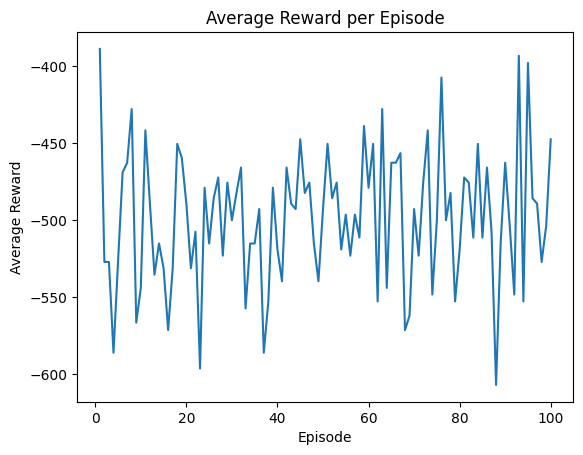

In [46]:
# max_episodes 만큼 반복.
average_rewards = []
best_average_reward = -1000

for episode in range(max_episodes):

    replace_failure = 0  # each episode 마다 초기화. 누적시킬 필요는 없음.
    state_index = 0      # state index -> index pointer로 취급하자. (episode 마다 초기화)
    total_reward = 0
    num_of_step = 0

    # cum_total_reward <- 이게 필요한가? reward는 각 episode별로 알면 끝인가? 아마 맞는듯. (나중에 다시 체크)

    # 하나의 episode는 전체 엔진을 모두 사용할 때까지!
    for unit_num in range(max_unit_number):  # unit num : 0, .... , (max_unit_number - 1)
        state = states.iloc[state_index].values


        # unit number가 바뀌기 전까지 반복 (망가지거나 replace 될 때까지;).
        #while state_index < len(environment) and environment['unit_number'].iloc[state_index] == (unit_num + 1):

        # out of bound 문제를 막기 위해 '최대 unit number - 1'의 끝에 도달하면 멈추게 함. 데이터에 마지막 더미 row를 추가해서, 원본 데이터를 모두 활용할 수 있도록 수정하자.
        while (state_index < environment[environment['unit_number'] == (environment['unit_number'].max() - 2)].index[-1] + 1) and environment['unit_number'].iloc[state_index] == (unit_num + 1):
            current_state = state

            # decay epsilon (linear)
            epsilon = max(min_epsilon, initial_epsilon - episode * epsilon_delta) # epsilon decay는 episode에 따라 감소해야함.

            # epsilon-greedy로 action 선택.
            if np.random.rand() < epsilon:
                chosen_action = np.random.choice(actions) # epsilon의 확률로 exploration.
            else:
                chosen_action = max(actions, key=lambda a: np.dot(weights[a], current_state)) # (1 - epsilon)의 확률로 greedy action.


            next_state_index = nextStateIndex(chosen_action, state_index)

            next_state = states.iloc[next_state_index].values # S_{t+1}

            # Target : R_{t+1} + gamma * q^
            # next state에서의 q-value, reward (R+1)를 알기 위해서는
            # next state에서 q-function을 바탕으로 내린 action을 통해 전이된 after_next state를 알아야 R_{t+1}을 계산할 수 있음.
            # next action은 argmax로 greedy 하게 뽑음 (off-policy; Q-Learning). SARSA로 하려면, 똑같이 next action도 epsilon greedy로 뽑아야 함.

            # R_t를 사용하므로, 아래 코드는 주석처리 ########
            """
            next_chosen_action = max(actions, key=lambda a: np.dot(weights[a], next_state)) # next action은 argmax로 greedy 하게 뽑음 (off-policy; Q-Learning).
            after_next_state_index = nextStateIndex(next_chosen_action, next_state_index)   # S_{t+2}
            """

            # R_{t+1}을 알려면 A_{t+1}을 기반으로 S_{t+2}까지 알아야함 (David Silver lecture 기준; 원래는 TD target에서 R_{t+1}이 아니라, R_t로 한다고 배움).
            # 여기서는 R_t로 적용.
            # R(S, S', A) 에 따른 리워드 계산

            current_reward = calculateReward(state_index, next_state_index, chosen_action)
            # next_reward = calculateReward(next_state_index, after_next_state_index, next_chosen_action) # 뒤에 2개 인자는 위에서 구해줘여함.

            # count 'replace failure'
            if current_reward == (-10000):
                replace_failure += 1

            # Q-value 업데이트 (Linear Function Approximation)
            next_state_q = max([np.dot(weights[a], next_state) for a in actions])  # A' greedy action
            current_state_q = np.dot(weights[chosen_action], current_state)       # A  ~ epsilon greedy

            # TD target도 next_reward가 아닌 current reward로 변경
            TD_target = current_reward + gamma * next_state_q
            delta_w = alpha * (TD_target - current_state_q) * current_state

            weights[chosen_action] = weights[chosen_action] + delta_w


            # 총 리워드 업데이트
            total_reward += current_reward

            # test code
            #print(f"chosen action : {chosen_action}, current reward : {current_reward}, state index : {state_index}")

            # 다음 상태로 이동
            state_index = next_state_index
            state = states.iloc[state_index].values
            num_of_step += 1

    # episode 학습 결과 출력
    average_reward = total_reward / num_of_step

    # best weight 저장
    if average_reward > best_average_reward:
      best_average_reward = copy(average_reward)
      best_weights = copy(weights)
      #print(weights)
      #print(best_weights)
      #print("save")

    average_rewards.append(average_reward)
    print(f"episode : {episode + 1}, replace failure : {replace_failure}, Average Reward : {average_reward}")
    #print(np.dot(weights['continue'], states.iloc[state_index].values))
    #print(np.dot(weights['replace'], states.iloc[state_index].values))


# episode에 따른 average reward
plt.plot(range(1, max_episodes + 1), average_rewards)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward per Episode')
plt.show()



# 학습이 완료된 weights를 사용하여 액션을 선택할 수 있음


In [47]:
print(weights['continue'])

[ 0.12191755 -0.35709812 -0.71386664 -0.2013889  -0.17603117 -0.37880308
  0.13301267  0.45590685  0.22802022  0.22540907  0.34744285 -0.23101239
 -0.35449543 -0.22274034 -0.11505528  0.90757024 -0.9100841   0.51797806
 -0.71707033 -0.09203429  0.04177027]


In [48]:
print(weights['replace'])

[  -0.65415607 -108.60324819 -122.66728256  -93.1755394     0.71496386
 -201.37743181 -202.71582255  -86.24195712  -50.42737261   -0.60273411
  -94.70701975 -217.63305504  -91.67252814  -56.62333864 -110.76179634
    0.4628032  -118.10459953    0.27884313   -0.27266215 -183.73013534
 -192.55921778]


In [49]:
print(best_weights['continue'])

[ 0.12191755 -0.37396299 -0.78127136 -0.23223094 -0.17603117 -0.6392848
  0.14006598  0.48900203  0.23772273  0.22540907  0.37530445 -0.25982583
 -0.35331721 -0.2135382  -0.11786356  0.90757024 -1.04612251  0.51797806
 -0.71707033 -0.14275184  0.02589888]


In [50]:
print(best_weights['replace'])

[  -0.65415607  -44.74725354  -45.54861786  -39.17679521    0.71496386
 -128.51204718  -84.49889176  -30.57263644  -20.39939948   -0.60273411
  -36.29417042  -87.16806253  -30.68747486  -24.03025497  -44.93334791
    0.4628032   -50.46776465    0.27884313   -0.27266215  -77.71170071
  -82.84191046]


**학습된 Q로 전체 데이터에 대해 성능 테스트**

In [51]:
# 함수 뒤에 dataset을 입력으로 받아서 train 함수와 동일하게 사용하자.

In [52]:
full_data

unit_number  time_cycles  setting_1  setting_2  setting_3  s_1  \
0                1            1    -0.0007    -0.0004      100.0  0.0   
1                1            2     0.0019    -0.0003      100.0  0.0   
2                1            3    -0.0043     0.0003      100.0  0.0   
3                1            4     0.0007     0.0000      100.0  0.0   
4                1            5    -0.0019    -0.0002      100.0  0.0   
...            ...          ...        ...        ...        ...  ...   
20626          100          196    -0.0004    -0.0003      100.0  0.0   
20627          100          197    -0.0016    -0.0005      100.0  0.0   
20628          100          198     0.0004     0.0000      100.0  0.0   
20629          100          199    -0.0011     0.0003      100.0  0.0   
20630          100          200    -0.0032    -0.0005      100.0  0.0   

            s_2       s_3       s_4  s_5  ...      s_13      s_14      s_15  \
0      0.183735  0.406802  0.309757  0.0  ...  0.205882  0.199608  0.363986   
1      0.283133  0.453019  0.352633  0.0  ...  0.279412  0.162813  0.411312   
2      0.343373  0.369523  0.370527  0.0  ...  0.220588  0.171793  0.357445   
3      0.343373  0.256159  0.331195  0.0  ...  0.294118  0.174889  0.166603   
4      0.349398  0.257467  0.404625  0.0  ...  0.235294  0.174734  0.402078   
...         ...       ...       ...  ...  ...       ...       ...       ...   
20626  0.686747  0.587312  0.782917  0.0  ...  0.558824  0.194344  0.656791   
20627  0.701807  0.729453  0.866475  0.0  ...  0.500000  0.188668  0.727203   
20628  0.665663  0.684979  0.775321  0.0  ...  0.529412  0.212148  0.922278   
20629  0.608434  0.746021  0.747468  0.0  ...  0.514706  0.203065  0.823394   
20630  0.795181  0.639634  0.842167  0.0  ...  0.558824  0.192951  0.687572   

       s_16      s_17  s_18  s_19      s_20      s_21  RUL  
0       0.0  0.333333   0.0   0.0  0.713178  0.724662  191  
1       0.0  0.333333   0.0   0.0  0.666667  0.731014  190  
2       0.0  0.166667   0.0   0.0  0.627907  0.621375  189  
3       0.0  0.333333   0.0   0.0  0.573643  0.662386  188  
4       0.0  0.416667   0.0   0.0  0.589147  0.704502  187  
...     ...       ...   ...   ...       ...       ...  ...  
20626   0.0  0.750000   0.0   0.0  0.271318  0.109500    4  
20627   0.0  0.583333   0.0   0.0  0.124031  0.366197    3  
20628   0.0  0.833333   0.0   0.0  0.232558  0.053991    2  
20629   0.0  0.583333   0.0   0.0  0.116279  0.234466    1  
20630   0.0  0.666667   0.0   0.0  0.178295  0.218172    0  

[20631 rows x 27 columns]

In [53]:
environment_test = full_data
states_test = environment_test[['s_{}'.format(i) for i in range(1, 22)]]

In [54]:
def calculateRewardTest(current_index, next_index, action):
    # 'unit_number' 열의 현재 및 다음 행 값 추출
    current_unit_number = environment_test['unit_number'].iloc[current_index]
    next_unit_number = environment_test['unit_number'].iloc[next_index]

    if action == 'continue':
        # 다음 'unit_number'가 바뀌지 않으면 0 (next state가 failure가 아님)
        if current_unit_number == next_unit_number:
          return r_continue
        # 다음 'unit_number'가 바뀌면 -10,000 (next state가 failure; replace 실패에 해당)
        else:
          return r_continue_but_failure
    elif action == 'replace':
      # 'Replace' 액션을 취한 경우, 다음 'unit_number'로 교체됨
      # 이 경우, 다음 'unit_number'가 1로 초기화되므로 -1,000의 보상을 줄 수 있음
      return r_replace

In [55]:
def nextStateIndexTest(action, current_index):
  # action에 따라 next state가 달라짐.
  if action == 'continue':
    return current_index + 1
  else:
    # replace인 경우 next_state는 다음 엔진(unit_number)의 첫번째 행.
    current_unit_number = environment_test['unit_number'].iloc[current_index]
    next_unit_initial_index = environment_test[environment_test['unit_number'] == current_unit_number].index[-1] + 1
    return next_unit_initial_index

In [56]:
max_unit_number = environment_test['unit_number'].max() # 마지막 unit_number를 return. (1~70이라면 70 반환)
replace_failure = 0
state_index = 0      # state index -> index pointer로 취급.
total_reward = 0
num_of_step = 0
average_rewards = 0
average_usage_time = 0

for unit_num in range(max_unit_number):  # unit num : 0, .... , (max_unit_number - 1)
    state = states_test.iloc[state_index].values

    # out of bound 문제를 막기 위해 '최대 unit number - 1'의 끝에 도달하면 멈추게 함. 데이터에 마지막 더미 row를 추가해서, 원본 데이터를 모두 활용할 수 있도록 수정하자.
    while (state_index < environment_test[environment_test['unit_number'] == (environment_test['unit_number'].max() - 2)].index[-1] + 1) and environment_test['unit_number'].iloc[state_index] == (unit_num + 1):
        current_state = state

        chosen_action = max(actions, key=lambda a: np.dot(best_weights[a], current_state))

        next_state_index = nextStateIndexTest(chosen_action, state_index)
        next_state = states_test.iloc[next_state_index].values # S_{t+1}
        current_reward = calculateRewardTest(state_index, next_state_index, chosen_action)

        # count 'replace failure'
        if current_reward == (-10000):
            replace_failure += 1
            #print(replace_failure)

        # 총 리워드 업데이트
        total_reward += current_reward

        # 다음 상태로 이동
        state_index = next_state_index
        state = states_test.iloc[state_index].values
        num_of_step += 1

# episode 학습 결과 출력
average_reward = total_reward / num_of_step
average_usage_time = num_of_step / (environment_test['unit_number'].max() - 2)
print(f"Number of Engine : {environment_test['unit_number'].max() - 2}, Average Reward : {average_reward}, replace failure : {replace_failure}, average usage time : {average_usage_time}")
#print(np.dot(weights['continue'], states_test.iloc[state_index].values))
#print(np.dot(weights['replace'], states_test.iloc[state_index].values))





Number of Engine : 98, Average Reward : -48.40462313543416, replace failure : 98, average usage time : 206.59183673469389


원래의 environment에서 실험 재현

# Q-value를 remaining useful life (RUL) prediction으로 convert

Best weights 가져오기

In [57]:
# best weights (by Q-learning best_weights; RL_Toy_Example_25)
save_weights = {
    "continue": np.random.normal(loc=0, scale=0.5, size=len(states.columns)),
    "replace": np.random.normal(loc=0, scale=0.5, size=len(states.columns))
}
save_weights["continue"] = [ 1.21917550e-01, -1.76674057e+03, -1.69654640e+03, -2.12784329e+03,
                            -1.76031172e-01, -5.41407715e+02,  1.71969275e+03, -1.42636484e+03,
                             -9.58899289e+02, 2.25409067e-01, -2.38937267e+03, 1.80436677e+03,
                             -1.32237276e+03, -7.75611348e+02, -1.84484215e+03, 9.07570238e-01,
                             -1.72423314e+03, 5.17978057e-01, -7.17070331e-01, 1.60180476e+03,
                             1.98753523e+03]
save_weights["replace"] = [-6.54156068e-01, -9.31194035e+02, -9.86249665e+02, -8.18887605e+02,
                           7.14963860e-01, -2.55475982e+03, -1.77602288e+03, -6.41691636e+02,
                           -4.08847651e+02, -6.02734107e-01, -7.70459163e+02, -1.85903546e+03,
                           -7.04479461e+02, -4.89540991e+02, -9.74286548e+02, 4.62803201e-01,
                           -1.06291167e+03, 2.78843125e-01, -2.72662147e-01, -1.62420478e+03,
                           -1.72686191e+03]

In [58]:
max_unit_number = environment_test['unit_number'].max() # 마지막 unit_number를 return. (1~70이라면 70 반환)
replace_failure = 0
state_index = 0      # state index -> index pointer로 취급.
total_reward = 0
num_of_step = 0
average_rewards = 0
average_usage_time = 0
replace_indices = []   # replace가 발생한 index를 저장하기 위한 배열 (이 배열을 이용해서 Replace가 발생할 때의 q-value를 알 수 있음)

for unit_num in range(max_unit_number):  # unit num : 0, .... , (max_unit_number - 1)
    state = states_test.iloc[state_index].values

    # out of bound 문제를 막기 위해 '최대 unit number - 1'의 끝에 도달하면 멈추게 함. 데이터에 마지막 더미 row를 추가해서, 원본 데이터를 모두 활용할 수 있도록 수정하자.
    while (state_index < environment_test[environment_test['unit_number'] == (environment_test['unit_number'].max() - 2)].index[-1] + 1) and environment_test['unit_number'].iloc[state_index] == (unit_num + 1):
        current_state = state

        chosen_action = max(actions, key=lambda a: np.dot(save_weights[a], current_state))

        next_state_index = nextStateIndexTest(chosen_action, state_index)
        next_state = states_test.iloc[next_state_index].values # S_{t+1}
        current_reward = calculateRewardTest(state_index, next_state_index, chosen_action)

        # count 'replace failure'
        if current_reward == (-10000):
            replace_failure += 1
            #print(replace_failure)

        # 총 리워드 업데이트
        total_reward += current_reward


        # next state로 가기 전에, action이 replace인 state를 저장.
        if(chosen_action == 'replace'):
          replace_indices.append(state_index)
          #print("saved")



        # 다음 상태로 이동
        state_index = next_state_index
        state = states_test.iloc[state_index].values
        num_of_step += 1

# episode 학습 결과 출력
average_reward = total_reward / num_of_step
average_usage_time = num_of_step / (environment_test['unit_number'].max() - 2)
print(f"Number of Engine : {environment_test['unit_number'].max() - 2}, Average Reward : {average_reward}, replace failure : {replace_failure}, average usage time : {average_usage_time}")
#print(np.dot(weights['continue'], states_test.iloc[state_index].values))
#print(np.dot(weights['replace'], states_test.iloc[state_index].values))
print(replace_indices)

Number of Engine : 98, Average Reward : -5.405132349969691, replace failure : 1, average usage time : 202.0
[183, 470, 657, 844, 1105, 1298, 1555, 1705, 1913, 2134, 2373, 2535, 2707, 2886, 3091, 3293, 3572, 3775, 3930, 4164, 4361, 4551, 4730, 4875, 5103, 5308, 5464, 5779, 5985, 6215, 6410, 6607, 6803, 6985, 7142, 7312, 7505, 7634, 7815, 8038, 8234, 8440, 8636, 8791, 9045, 9257, 9495, 9702, 9899, 10121, 10327, 10529, 10778, 10976, 11248, 11386, 11535, 11765, 11940, 12121, 12300, 12476, 12751, 12914, 13108, 13415, 13629, 13980, 14124, 14337, 14541, 14752, 14927, 15153, 15360, 15517, 15747, 15949, 16134, 16372, 16591, 16881, 17142, 17335, 17605, 17791, 18008, 18220, 18378, 18507, 18852, 19006, 19260, 19551, 19876, 20089, 20245]


**Q(Continue - Replace)를 위한 weights 수정**

In [59]:
c_threshold = 1
slicing_index = 4  # 5번째 값을 슬라이싱으로 제거하기 위한 index.
dummy_state_value = -50  # constant인 state를 min-max scaler에 통과시키면, 0이므로 이 값을 대체하기 위해 아주 작은 수 입력 (음수를 넣어야 부등호 방향이 맞음).

weights_difference = np.array(save_weights["continue"]) - np.array(save_weights["replace"])
weights_difference

array([ 7.76073618e-01, -8.35546535e+02, -7.10296735e+02, -1.30895568e+03,
       -8.90995032e-01,  2.01335211e+03,  3.49571563e+03, -7.84673204e+02,
       -5.50051638e+02,  8.28143174e-01, -1.61891351e+03,  3.66340223e+03,
       -6.17893299e+02, -2.86070357e+02, -8.70555602e+02,  4.44767037e-01,
       -6.61321470e+02,  2.39134932e-01, -4.44408184e-01,  3.22600954e+03,
        3.71439714e+03])

**State 중 constant인 index에 대응되는 weights의 index 추출.**

In [60]:
weights_constant = weights_difference[slicing_index] # (slicing_index + 1)의 값을 저장. (나중에 나누기 위함)
weights_difference = np.delete(weights_difference, slicing_index) # (slicing_index + 1)의 값을 슬라이싱으로 제거.
print(weights_constant)
print(weights_difference)

-0.890995032
[ 7.76073618e-01 -8.35546535e+02 -7.10296735e+02 -1.30895568e+03
  2.01335211e+03  3.49571563e+03 -7.84673204e+02 -5.50051638e+02
  8.28143174e-01 -1.61891351e+03  3.66340223e+03 -6.17893299e+02
 -2.86070357e+02 -8.70555602e+02  4.44767037e-01 -6.61321470e+02
  2.39134932e-01 -4.44408184e-01  3.22600954e+03  3.71439714e+03]


**Weights를 'C / (s_i * w_i)' 로 나누기**

In [61]:
temp = c_threshold / (dummy_state_value * weights_constant)
print(temp)

0.022446814271350504


In [62]:
weights_difference *= temp
print(weights_difference)

[ 1.74203804e-02 -1.87553579e+01 -1.59438989e+01 -2.93818852e+01
  4.51933408e+01  7.84676795e+01 -1.76134137e+01 -1.23469070e+01
  1.85891760e-02 -3.63394508e+01  8.22317095e+01 -1.38697361e+01
 -6.42136817e+00 -1.95411999e+01  9.98360307e-03 -1.48445602e+01
  5.36781740e-03 -9.97554797e-03  7.24136370e+01  8.33763827e+01]


In [63]:
RL_results = states_test
RL_results

s_1       s_2       s_3       s_4  s_5  s_6       s_7       s_8  \
0      0.0  0.183735  0.406802  0.309757  0.0  1.0  0.726248  0.242424   
1      0.0  0.283133  0.453019  0.352633  0.0  1.0  0.628019  0.212121   
2      0.0  0.343373  0.369523  0.370527  0.0  1.0  0.710145  0.272727   
3      0.0  0.343373  0.256159  0.331195  0.0  1.0  0.740741  0.318182   
4      0.0  0.349398  0.257467  0.404625  0.0  1.0  0.668277  0.242424   
...    ...       ...       ...       ...  ...  ...       ...       ...   
20626  0.0  0.686747  0.587312  0.782917  0.0  1.0  0.254428  0.439394   
20627  0.0  0.701807  0.729453  0.866475  0.0  1.0  0.162641  0.500000   
20628  0.0  0.665663  0.684979  0.775321  0.0  1.0  0.175523  0.515152   
20629  0.0  0.608434  0.746021  0.747468  0.0  1.0  0.133655  0.530303   
20630  0.0  0.795181  0.639634  0.842167  0.0  1.0  0.151369  0.545455   

            s_9  s_10  ...      s_12      s_13      s_14      s_15  s_16  \
0      0.109755   0.0  ...  0.633262  0.205882  0.199608  0.363986   0.0   
1      0.100242   0.0  ...  0.765458  0.279412  0.162813  0.411312   0.0   
2      0.140043   0.0  ...  0.795309  0.220588  0.171793  0.357445   0.0   
3      0.124518   0.0  ...  0.889126  0.294118  0.174889  0.166603   0.0   
4      0.149960   0.0  ...  0.746269  0.235294  0.174734  0.402078   0.0   
...         ...   ...  ...       ...       ...       ...       ...   ...   
20626  0.196491   0.0  ...  0.170576  0.558824  0.194344  0.656791   0.0   
20627  0.194651   0.0  ...  0.211087  0.500000  0.188668  0.727203   0.0   
20628  0.198196   0.0  ...  0.281450  0.529412  0.212148  0.922278   0.0   
20629  0.233285   0.0  ...  0.208955  0.514706  0.203065  0.823394   0.0   
20630  0.178363   0.0  ...  0.130064  0.558824  0.192951  0.687572   0.0   

           s_17  s_18  s_19      s_20      s_21  
0      0.333333   0.0   0.0  0.713178  0.724662  
1      0.333333   0.0   0.0  0.666667  0.731014  
2      0.166667   0.0   0.0  0.627907  0.621375  
3      0.333333   0.0   0.0  0.573643  0.662386  
4      0.416667   0.0   0.0  0.589147  0.704502  
...         ...   ...   ...       ...       ...  
20626  0.750000   0.0   0.0  0.271318  0.109500  
20627  0.583333   0.0   0.0  0.124031  0.366197  
20628  0.833333   0.0   0.0  0.232558  0.053991  
20629  0.583333   0.0   0.0  0.116279  0.234466  
20630  0.666667   0.0   0.0  0.178295  0.218172  

[20631 rows x 21 columns]

**s_5 drop!**

In [64]:
RL_results = RL_results.drop('s_5', axis=1)
RL_results

s_1       s_2       s_3       s_4  s_6       s_7       s_8       s_9  \
0      0.0  0.183735  0.406802  0.309757  1.0  0.726248  0.242424  0.109755   
1      0.0  0.283133  0.453019  0.352633  1.0  0.628019  0.212121  0.100242   
2      0.0  0.343373  0.369523  0.370527  1.0  0.710145  0.272727  0.140043   
3      0.0  0.343373  0.256159  0.331195  1.0  0.740741  0.318182  0.124518   
4      0.0  0.349398  0.257467  0.404625  1.0  0.668277  0.242424  0.149960   
...    ...       ...       ...       ...  ...       ...       ...       ...   
20626  0.0  0.686747  0.587312  0.782917  1.0  0.254428  0.439394  0.196491   
20627  0.0  0.701807  0.729453  0.866475  1.0  0.162641  0.500000  0.194651   
20628  0.0  0.665663  0.684979  0.775321  1.0  0.175523  0.515152  0.198196   
20629  0.0  0.608434  0.746021  0.747468  1.0  0.133655  0.530303  0.233285   
20630  0.0  0.795181  0.639634  0.842167  1.0  0.151369  0.545455  0.178363   

       s_10      s_11      s_12      s_13      s_14      s_15  s_16      s_17  \
0       0.0  0.369048  0.633262  0.205882  0.199608  0.363986   0.0  0.333333   
1       0.0  0.380952  0.765458  0.279412  0.162813  0.411312   0.0  0.333333   
2       0.0  0.250000  0.795309  0.220588  0.171793  0.357445   0.0  0.166667   
3       0.0  0.166667  0.889126  0.294118  0.174889  0.166603   0.0  0.333333   
4       0.0  0.255952  0.746269  0.235294  0.174734  0.402078   0.0  0.416667   
...     ...       ...       ...       ...       ...       ...   ...       ...   
20626   0.0  0.726190  0.170576  0.558824  0.194344  0.656791   0.0  0.750000   
20627   0.0  0.708333  0.211087  0.500000  0.188668  0.727203   0.0  0.583333   
20628   0.0  0.738095  0.281450  0.529412  0.212148  0.922278   0.0  0.833333   
20629   0.0  0.916667  0.208955  0.514706  0.203065  0.823394   0.0  0.583333   
20630   0.0  0.803571  0.130064  0.558824  0.192951  0.687572   0.0  0.666667   

       s_18  s_19      s_20      s_21  
0       0.0   0.0  0.713178  0.724662  
1       0.0   0.0  0.666667  0.731014  
2       0.0   0.0  0.627907  0.621375  
3       0.0   0.0  0.573643  0.662386  
4       0.0   0.0  0.589147  0.704502  
...     ...   ...       ...       ...  
20626   0.0   0.0  0.271318  0.109500  
20627   0.0   0.0  0.124031  0.366197  
20628   0.0   0.0  0.232558  0.053991  
20629   0.0   0.0  0.116279  0.234466  
20630   0.0   0.0  0.178295  0.218172  

[20631 rows x 20 columns]

**Weights를 바탕으로 RUL_prediction (Q-value의 weight으로)**

In [65]:
RL_results['predicted RUL'] = RL_results.apply(lambda row: np.dot(weights_difference, row), axis=1)
RL_results

s_1       s_2       s_3       s_4  s_6       s_7       s_8       s_9  \
0      0.0  0.183735  0.406802  0.309757  1.0  0.726248  0.242424  0.109755   
1      0.0  0.283133  0.453019  0.352633  1.0  0.628019  0.212121  0.100242   
2      0.0  0.343373  0.369523  0.370527  1.0  0.710145  0.272727  0.140043   
3      0.0  0.343373  0.256159  0.331195  1.0  0.740741  0.318182  0.124518   
4      0.0  0.349398  0.257467  0.404625  1.0  0.668277  0.242424  0.149960   
...    ...       ...       ...       ...  ...       ...       ...       ...   
20626  0.0  0.686747  0.587312  0.782917  1.0  0.254428  0.439394  0.196491   
20627  0.0  0.701807  0.729453  0.866475  1.0  0.162641  0.500000  0.194651   
20628  0.0  0.665663  0.684979  0.775321  1.0  0.175523  0.515152  0.198196   
20629  0.0  0.608434  0.746021  0.747468  1.0  0.133655  0.530303  0.233285   
20630  0.0  0.795181  0.639634  0.842167  1.0  0.151369  0.545455  0.178363   

       s_10      s_11  ...      s_13      s_14      s_15  s_16      s_17  \
0       0.0  0.369048  ...  0.205882  0.199608  0.363986   0.0  0.333333   
1       0.0  0.380952  ...  0.279412  0.162813  0.411312   0.0  0.333333   
2       0.0  0.250000  ...  0.220588  0.171793  0.357445   0.0  0.166667   
3       0.0  0.166667  ...  0.294118  0.174889  0.166603   0.0  0.333333   
4       0.0  0.255952  ...  0.235294  0.174734  0.402078   0.0  0.416667   
...     ...       ...  ...       ...       ...       ...   ...       ...   
20626   0.0  0.726190  ...  0.558824  0.194344  0.656791   0.0  0.750000   
20627   0.0  0.708333  ...  0.500000  0.188668  0.727203   0.0  0.583333   
20628   0.0  0.738095  ...  0.529412  0.212148  0.922278   0.0  0.833333   
20629   0.0  0.916667  ...  0.514706  0.203065  0.823394   0.0  0.583333   
20630   0.0  0.803571  ...  0.558824  0.192951  0.687572   0.0  0.666667   

       s_18  s_19      s_20      s_21  predicted RUL  
0       0.0   0.0  0.713178  0.724662     212.050571  
1       0.0   0.0  0.666667  0.731014     207.024324  
2       0.0   0.0  0.627907  0.621375     211.135690  
3       0.0   0.0  0.573643  0.662386     226.339032  
4       0.0   0.0  0.589147  0.704502     204.002324  
...     ...   ...       ...       ...            ...  
20626   0.0   0.0  0.271318  0.109500      -6.807738  
20627   0.0   0.0  0.124031  0.366197      -3.391046  
20628   0.0   0.0  0.232558  0.053991     -20.174712  
20629   0.0   0.0  0.116279  0.234466     -23.159280  
20630   0.0   0.0  0.178295  0.218172     -24.322006  

[20631 rows x 21 columns]

**Replace가 발생했을 때의 RUL prediction 값을 출력 (dummy_state_value를 조정해 threshold와 맞추기 위해)**

In [66]:
for index in replace_indices:
    rul_prediction = RL_results.loc[index, 'predicted RUL']
    print(f'Index {index}: predicted RUL = {rul_prediction}')

Index 183: predicted RUL = -12.661607142348004
Index 470: predicted RUL = -0.2367055769187374
Index 657: predicted RUL = -20.448315673150944
Index 844: predicted RUL = -1.5046480330411072
Index 1105: predicted RUL = -7.367355432636401
Index 1298: predicted RUL = -9.736388769926812
Index 1555: predicted RUL = -9.422332583771862
Index 1705: predicted RUL = -7.249437296295973
Index 1913: predicted RUL = -13.911446222626452
Index 2134: predicted RUL = -12.393852784517257
Index 2373: predicted RUL = -1.400421253602616
Index 2535: predicted RUL = -4.594778813172688
Index 2707: predicted RUL = -3.514117304025021
Index 2886: predicted RUL = -4.563390703693244
Index 3091: predicted RUL = -1.131848597184593
Index 3293: predicted RUL = -21.478416012217664
Index 3572: predicted RUL = -0.2586267615212492
Index 3775: predicted RUL = -28.031721598727827
Index 3930: predicted RUL = -18.54202961917899
Index 4164: predicted RUL = -5.798010583788212
Index 4361: predicted RUL = -10.090665385293448
Index 4

**Label이 있는 원래 dataframe에 RUL_prediction column 추가.**

In [67]:
# 'full_data' 데이터프레임과 'RL_results' 데이터프레임을 병합 (full_data의 column 끝에 'RUL_prediction을 추가한 후 새롭게 저장)
final_data = pd.concat([full_data, RL_results['predicted RUL']], axis=1)
final_data

unit_number  time_cycles  setting_1  setting_2  setting_3  s_1  \
0                1            1    -0.0007    -0.0004      100.0  0.0   
1                1            2     0.0019    -0.0003      100.0  0.0   
2                1            3    -0.0043     0.0003      100.0  0.0   
3                1            4     0.0007     0.0000      100.0  0.0   
4                1            5    -0.0019    -0.0002      100.0  0.0   
...            ...          ...        ...        ...        ...  ...   
20626          100          196    -0.0004    -0.0003      100.0  0.0   
20627          100          197    -0.0016    -0.0005      100.0  0.0   
20628          100          198     0.0004     0.0000      100.0  0.0   
20629          100          199    -0.0011     0.0003      100.0  0.0   
20630          100          200    -0.0032    -0.0005      100.0  0.0   

            s_2       s_3       s_4  s_5  ...      s_14      s_15  s_16  \
0      0.183735  0.406802  0.309757  0.0  ...  0.199608  0.363986   0.0   
1      0.283133  0.453019  0.352633  0.0  ...  0.162813  0.411312   0.0   
2      0.343373  0.369523  0.370527  0.0  ...  0.171793  0.357445   0.0   
3      0.343373  0.256159  0.331195  0.0  ...  0.174889  0.166603   0.0   
4      0.349398  0.257467  0.404625  0.0  ...  0.174734  0.402078   0.0   
...         ...       ...       ...  ...  ...       ...       ...   ...   
20626  0.686747  0.587312  0.782917  0.0  ...  0.194344  0.656791   0.0   
20627  0.701807  0.729453  0.866475  0.0  ...  0.188668  0.727203   0.0   
20628  0.665663  0.684979  0.775321  0.0  ...  0.212148  0.922278   0.0   
20629  0.608434  0.746021  0.747468  0.0  ...  0.203065  0.823394   0.0   
20630  0.795181  0.639634  0.842167  0.0  ...  0.192951  0.687572   0.0   

           s_17  s_18  s_19      s_20      s_21  RUL  predicted RUL  
0      0.333333   0.0   0.0  0.713178  0.724662  191     212.050571  
1      0.333333   0.0   0.0  0.666667  0.731014  190     207.024324  
2      0.166667   0.0   0.0  0.627907  0.621375  189     211.135690  
3      0.333333   0.0   0.0  0.573643  0.662386  188     226.339032  
4      0.416667   0.0   0.0  0.589147  0.704502  187     204.002324  
...         ...   ...   ...       ...       ...  ...            ...  
20626  0.750000   0.0   0.0  0.271318  0.109500    4      -6.807738  
20627  0.583333   0.0   0.0  0.124031  0.366197    3      -3.391046  
20628  0.833333   0.0   0.0  0.232558  0.053991    2     -20.174712  
20629  0.583333   0.0   0.0  0.116279  0.234466    1     -23.159280  
20630  0.666667   0.0   0.0  0.178295  0.218172    0     -24.322006  

[20631 rows x 28 columns]

Replace가 일어난 state 출력.

In [68]:
for index in replace_indices:
    # final_data에서 해당 인덱스의 행 선택하여 필요한 열 출력
    row = final_data.loc[[index], ['unit_number', 'RUL', 'predicted RUL']]
    print(f"Index: {index}")
    print(row)

Index: 183
     unit_number  RUL  predicted RUL
183            1    8     -12.661607
Index: 470
     unit_number  RUL  predicted RUL
470            2    8      -0.236706
Index: 657
     unit_number  RUL  predicted RUL
657            3    0     -20.448316
Index: 844
     unit_number  RUL  predicted RUL
844            4    2      -1.504648
Index: 1105
      unit_number  RUL  predicted RUL
1105            5   10      -7.367355
Index: 1298
      unit_number  RUL  predicted RUL
1298            6    5      -9.736389
Index: 1555
      unit_number  RUL  predicted RUL
1555            7    7      -9.422333
Index: 1705
      unit_number  RUL  predicted RUL
1705            8    7      -7.249437
Index: 1913
      unit_number  RUL  predicted RUL
1913            9    0     -13.911446
Index: 2134
      unit_number  RUL  predicted RUL
2134           10    1     -12.393853
Index: 2373
      unit_number  RUL  predicted RUL
2373           11    2      -1.400421
Index: 2535
      unit_number  RUL  predicte

**Online prediction 시각화**

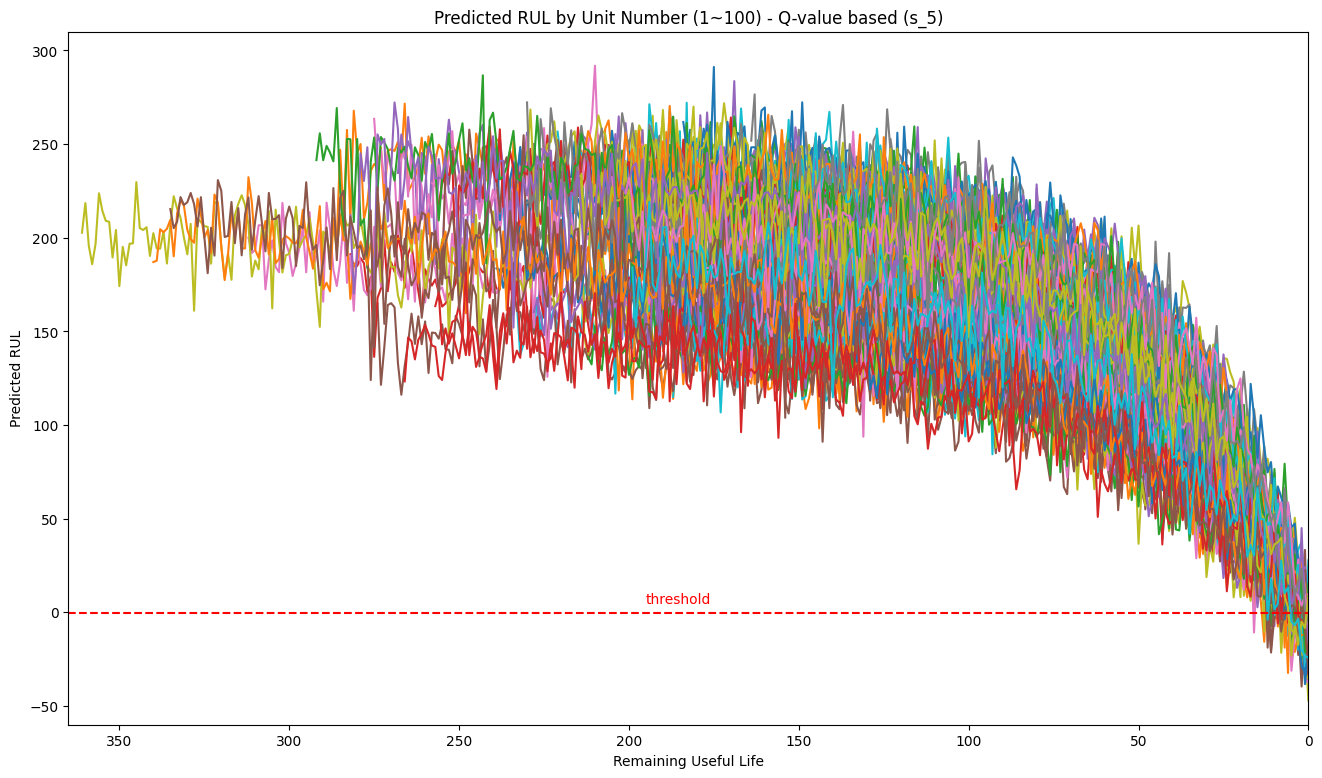

In [71]:
# 데이터프레임에서 unit_number을 기준으로 그룹화
grouped = final_data.groupby('unit_number')

# 그래프를 그릴 subplot을 설정
fig, ax = plt.subplots(figsize=(16, 9))

# unit_number 별로 그래프 그리기
for unit, group in grouped:
    ax.plot(group['RUL'], group['predicted RUL'], label=f'Unit {unit}')

ax.axhline(y=-0.5, color='r', linestyle='--', label='threshold')  # threshold를 점선으로 표현
ax.text(195, 5, 'threshold', color='r')  # 'threshold' 텍스트 추가


ax.set_xlabel('Remaining Useful Life')
ax.set_ylabel('Predicted RUL')
ax.set_title(f'Predicted RUL by Unit Number (1~100) - Q-value based (s_5)')
#ax.legend(loc='upper right')  # 범례 추가

# 그래프 출력 설정
plt.xlim(365, 0)  # reverse the x-axis so RUL counts down to zero
plt.ylim(-60, 310)
plt.show()

**비교를 위해 unit_number 71~100만 출력.**

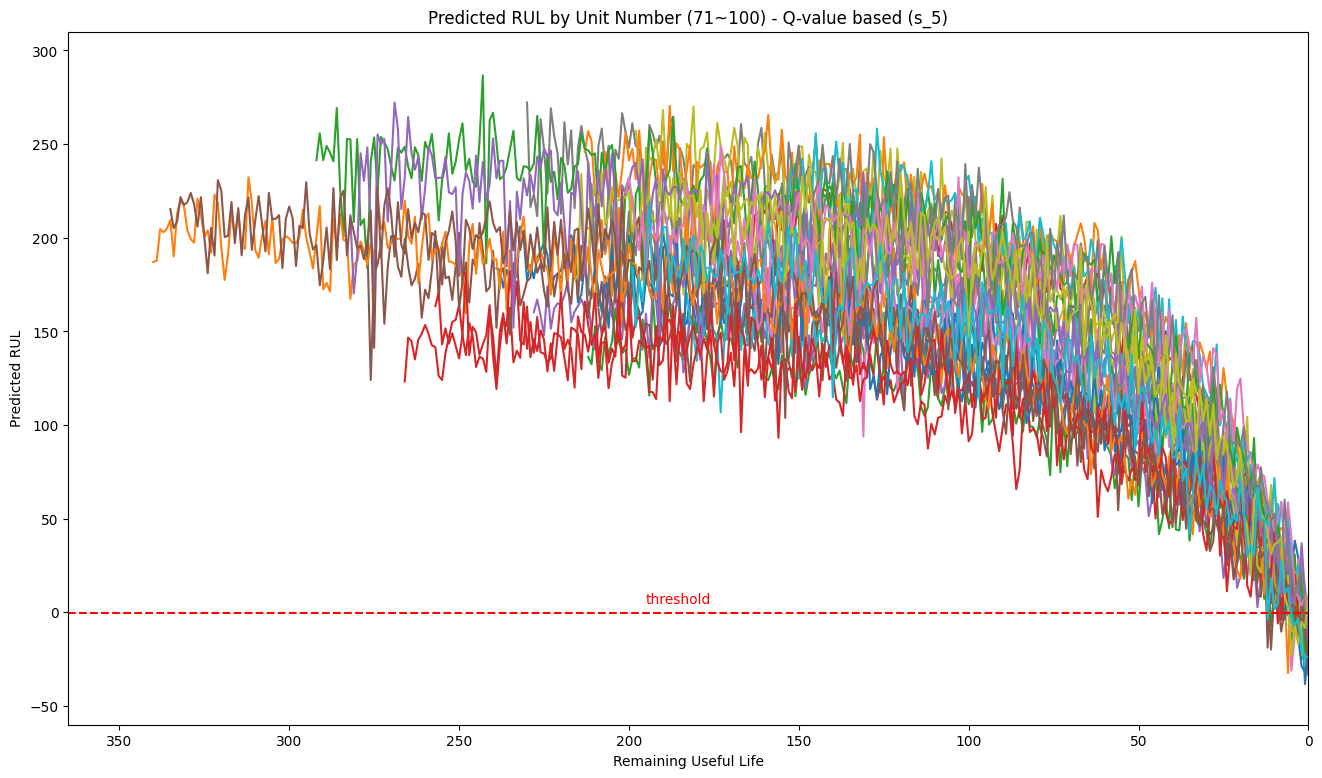

In [72]:
# 데이터프레임에서 unit_number을 기준으로 그룹화
filtered_data = final_data[(final_data['unit_number'] >= 71) & (final_data['unit_number'] <= 100)]  # 71~100 범위의 unit_number 필터링
grouped = filtered_data.groupby('unit_number')

# 그래프를 그릴 subplot을 설정
fig, ax = plt.subplots(figsize=(16, 9))

# unit_number 별로 그래프 그리기
for unit, group in grouped:
    ax.plot(group['RUL'], group['predicted RUL'], label=f'Unit {unit}')

ax.axhline(y=-0.5, color='r', linestyle='--', label='threshold')  # threshold를 점선으로 표현
ax.text(195, 5, 'threshold', color='r')  # 'threshold' 텍스트 추가

ax.set_xlabel('Remaining Useful Life')
ax.set_ylabel('Predicted RUL')
ax.set_title(f'Predicted RUL by Unit Number (71~100) - Q-value based (s_5)')

# 범례 추가
#ax.legend(loc='upper right')

# 그래프 출력 설정
plt.xlim(365, 0)  # reverse the x-axis so RUL counts down to zero
plt.ylim(-60, 310)
plt.show()